In [1]:
from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy

%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
    
def snr(pure, noisy):
    sig_pow = np.nanmean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.nanmean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db

from under_construction.fft.bit_reversal_fftshift import bit_reversed_indexes
from under_construction.fft.fft_core import R2SDFSFIX, R2SDF
from under_construction.fft.packager import DataWithIndex, unpackage, package

def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
    
def show_plot():
    plt.tight_layout()
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()
    
def bit_reverse(x, n_bits):
    return int(np.binary_repr(x, n_bits)[::-1], 2)

def bit_reversed_indexes(N):
    return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

from pyha import Hardware, simulate, sims_close, Complex, Sfix
from pyha.common.float import *
# Float.use_float16 = True
# Float.use_float16 = False

from mpmath import mp 
results = {}


# FFT

In [2]:
from pyha.common.shift_register import ShiftRegister
from under_construction.fft.packager import DataWithIndex, unpackage, package

def W(k, N):
    """ e^-j*2*PI*k*n/N, argument k = k * n """
    return np.exp(-1j * (2 * np.pi / N) * k)

class StageR2SDF(Hardware):
    def __init__(self, fft_size):
        self.FFT_SIZE = fft_size
        self.FFT_HALF = fft_size // 2

        self.CONTROL_MASK = (self.FFT_HALF - 1)
        self.shr = ShiftRegister([ComplexFloat() for _ in range(self.FFT_HALF)])

#         self.TWIDDLES = [Complex(W(i, self.FFT_SIZE), 0, -7, overflow_style='saturate', round_style='round') for i in range(self.FFT_HALF)]
        self.TWIDDLES = [ComplexFloat(W(i, self.FFT_SIZE), 2, 9) for i in range(self.FFT_HALF)]
        # self.TWIDDLES = [W(i, self.FFT_SIZE) for i in range(self.FFT_HALF)]

    def butterfly(self, in_up, in_down, twiddle):
        print(twiddle.real)
        up = in_up + in_down
        down_part = in_up - in_down
        down = down_part * twiddle
        return up, down

    def main(self, x, control):
        if not (control & self.FFT_HALF):
            self.shr.push_next(x)
            return self.shr.peek()
        else:
            twid = self.TWIDDLES[control & self.CONTROL_MASK]
            up, down = self.butterfly(self.shr.peek(), x, twid)

            # if self.FFT_HALF > 4:
            #     down >>= 1
            #     up >>= 1

            self.shr.push_next(down)
            return up


class R2SDF(Hardware):
    def __init__(self, fft_size):
        self.FFT_SIZE = fft_size

        self.n_bits = int(np.log2(fft_size))
        self.stages = [StageR2SDF(2 ** (pow + 1)) for pow in reversed(range(self.n_bits))]

        # Note: it is NOT correct to use this gain after the magnitude/abs operation, it has to be applied to complex values
        self.GAIN_CORRECTION = 2 ** (0 if self.n_bits - 3 < 0 else -(self.n_bits - 3))
        self.DELAY = (fft_size - 1) + 1  # +1 is output register

        self.out = DataWithIndex(ComplexFloat(), 0)

    def main(self, x):
        # #execute stages
        out = x.data
        for stage in self.stages:
            out = stage.main(out, x.index)

        self.out.data = out
        self.out.index = (x.index + self.DELAY + 1) % self.FFT_SIZE
        self.out.valid = x.valid
        return self.out

    def model_main(self, x):
        ffts = np.fft.fft(x)

        # apply bit reversing ie. mess up the output order to match radix-2 algorithm
        # from under_construction.fft.bit_reversal import bit_reversed_indexes
        def bit_reverse(x, n_bits):
            return int(np.binary_repr(x, n_bits)[::-1], 2)

        def bit_reversed_indexes(N):
            return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

        rev_index = bit_reversed_indexes(self.FFT_SIZE)
#         for i, _ in enumerate(ffts):
#             ffts[i] = ffts[i][rev_index]
        ffts = ffts[rev_index]
        # apply gain control (to avoid overflows in hardware)
        ffts *= self.GAIN_CORRECTION

        return ffts
    
def postprocess(x):
    pyh = x
    pyh = pyh[bit_reversed_indexes(fft_size)]
    pyh = np.fft.fftshift(pyh)
    pyh = [complex(x) for x in pyh]
    pyh = np.abs(pyh)
    pyh = pyh / pyh.max()
    return pyh

In [3]:
fft_size = 1024 * 2 * 2 * 2

# sig = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 100) * 0.25
# sig = sig * hann_fix9

# sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 110) * 0.25
# sig2 = sig2 * hann_fix9

# sig = sig + sig2

sig = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 1000)
# for i in range(800, 1000, 2):
#     sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * i * -1)
#     sig = sig + sig2

def awgn(iq, scale):
    r =  iq
    # r = np.copy(iq)
    r.real += np.random.normal(scale=scale, size=iq.shape)
    r.imag += np.random.normal(scale=scale, size=iq.shape)
    return r

# sig = awgn(sig, 0.01)
    
# sig *= 1 / 2 / 2 / 2 /2 / 2 / 2 / 2 / 2 / 2 /2 /2 /2 /2 /2 / 2 /2 /2 /2
# sig *= 1 / 2 / 2 / 2 /2 / 2 / 2 / 2 / 2 / 2 / 2
# sig = np.array([Complex(x, 0, -11, overflow_style='saturate').val for x in  sig]) # simulate ADC
sig *= np.hanning(fft_size)
# sig_fix *= hann_fix9

/usr/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


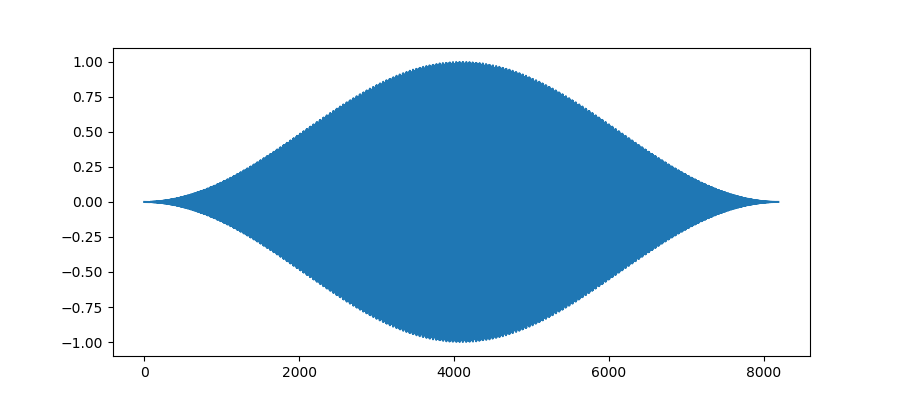

<IPython.core.display.Javascript object>


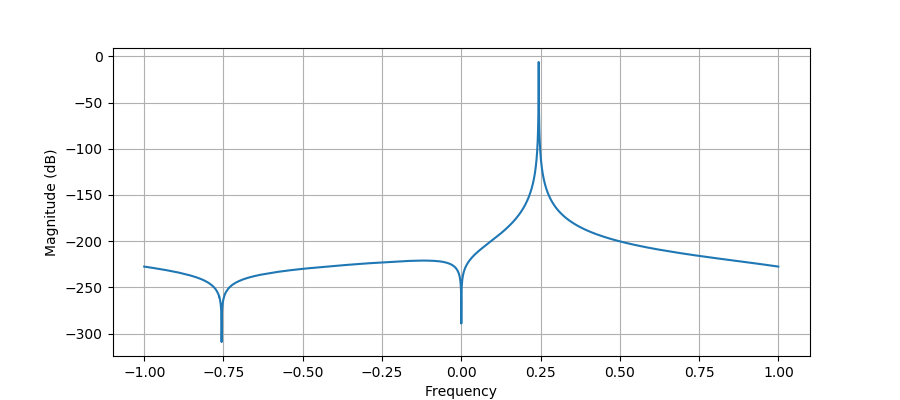

In [4]:
plt.plot(sig)
plt.show()

plt.magnitude_spectrum(sig, window=matplotlib.mlab.window_none, scale='dB')
plt.grid()
plt.show()

In [5]:
dut = R2SDF(fft_size)
sims = simulate(dut, sig, input_types=[ComplexFloat()], simulations=['MODEL', 'PYHA'], output_callback=unpackage, input_callback=package)
results['Float64'] = postprocess(np.array([complex(x) for x in sims['MODEL']]))
results['Radix32'] = postprocess(np.array([complex(x) for x in sims['PYHA'][0]]))

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


  0%|          | 0/16384 [00:00<?, ?it/s]1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.923828125000000 -:00:11101100

  2%|▏         | 271/16384 [00:00<00:05, 2708.76it/s]0.982421875000000 +:00:111110111
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.978515625000000 +:00:111110101
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.976562500000000 +:00:111110100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.972656250000000 +:00:111110010
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.966796875000000 +:00:111101111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.962890625000000 +:00:111101101
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.960937500000000 +:0

0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.183593750000000 -:00:001011110
0.933593750000000 +:00:111011110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.207031250000000 -:00:001101010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.218750000000000 -:00:001110000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.230468750000000 -:00:001110110
0.892578125000000 +:00:111001001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.242187500000000 -:00:001111100


  3%|▎         | 464/16384 [00:00<00:06, 2312.83it/s]-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.837890625000000 -:00:110101101
-0.404296875000000 -:00:011001111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.845703125000000 -:00:110110001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.851562500000000 -:00:110110100
-0.449218750000000 -:00:011100110
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.863281250000000 -:00:110111010
-0.492187500000000 -:00:011111100
0.513671875000000 +:00:100000111
0.554687500

  4%|▍         | 656/16384 [00:00<00:07, 2179.61it/s]0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.628906250000000 +:00:101000010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.625000000000000 +:00:101000000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.619140625000000 +:00:100111101
0.892578125000000 +:00:111001001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.615234375000000 +:00:100111011
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.611328125000000 +:00:100111001
0.869140625000000 +:00:110111101
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.605468750000000 +:00:100110110
0.857421875000000 +:00:110110111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:

  5%|▌         | 830/16384 [00:00<00:07, 2068.60it/s]-0.371093750000000 -:00:010111110
0.724609375000000 +:00:101110011
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.376953125000000 -:00:011000001
0.714843750000000 +:00:101101110
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.388671875000000 -:00:011000111
0.699218750000000 +:00:101100110
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.394531250000000 -:00:011001010
0.689453125000000 +:00:101100001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.400390625000000 -:00:011001101
0.679687500000000 +:00:101011100
0.98828125

  6%|▌         | 993/16384 [00:00<00:07, 1979.74it/s]-0.982421875000000 -:00:111110111
-0.927734375000000 -:00:111011011
-0.724609375000000 -:00:101110011
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.982421875000000 -:00:111110111
-0.933593750000000 -:00:111011110
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.984375000000000 -:00:111111000
-0.937500000000000 -:00:111100000
-0.757812500000000 -:00:110000100
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.984375000000000 -:00:111111000
-0.941406250000000 -:00:111100010
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.986328125000000 -:00:111111001
-0.945312500000000 -:00:111100100
-0.789062500000000 -:00:110010100
-0.2

  7%|▋         | 1184/16384 [00:00<00:07, 1967.70it/s]0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.880859375000000 +:00:111000011
0.689453125000000 +:00:101100001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
0.878906250000000 +:00:111000010
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.876953125000000 +:00:111000001
0.652343750000000 +:00:101001110
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.876953125000000 +:00:111000001
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.875000000000000 +:00:111000000
0.615234375000000 +:00:100111011
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.873046875000000 +:00:110111111
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10

-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.519531250000000 +:00:100001010
0.576171875000000 +:00:100100111
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.517578125000000 +:00:100001001
0.566406250000000 +:00:100100010
0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.513671875000000 +:00:100000111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
  8%|▊         | 1361/16384 [00:00<00:07, 1938.85it/s]0.511718750000000 +:00:100000110
0.544921875000000 +:00:100010111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.509765625000000 +:00:100000101
0.535156250000000 +:00:100010010
0.634765625000000 +:00:101000101
0.923828125000000 

0.191406250000000 +:00:001100010
-0.714843750000000 -:00:101101110
-0.024536132812500 -:11:110010010
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
0.189453125000000 +:00:001100001
-0.724609375000000 -:00:101110011
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
0.185546875000000 +:00:001011111
-0.732421875000000 -:00:101110111
-0.074218750000000 -:00:000100110
0.988281250000000 +:00:111111010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.183593750000000 +:00:001011110
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.179687500000000 +:00:001011100
-0.750000000000000 -:00:110000000
-0.123046875000000 -:00:000111111
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.177734375000000 +:00:001011011
-0.757812500000000 -:00:110000100
-0.146484375000000 -:00:00100101

-0.335937500000000 -:00:010101100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.074218750000000 +:00:000100110
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.070312500000000 +:00:000100100
-0.960937500000000 -:00:111101100
-0.845703125000000 -:00:110110001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.068359375000000 +:00:000100011
-0.962890625000000 -:00:111101101
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.064453125000000 +:00:000100001
-0.966796875000000 -:00:111101111
-0.869140625000000 -:00:110111101
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110

1.000000000000000 +:01:000010000
-0.351562500000000 -:00:010110100
0.753906250000000 +:00:110000010
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.353515625000000 -:00:010110101
0.750000000000000 +:00:110000000
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.357421875000000 -:00:010110111
0.744140625000000 +:00:101111101
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.359375000000000 -:00:010111000
0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.363281250000000 -:00:010111

 10%|█         | 1694/16384 [00:00<00:07, 1856.79it/s]-0.466796875000000 -:00:011101111
0.566406250000000 +:00:100100010
0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.468750000000000 -:00:011110000
0.560546875000000 +:00:100011111
0.724609375000000 +:00:101110011
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.474609375000000 -:00:011110011
0.550781250000000 +:00:100011010
0.689453125000000 +:00:101100001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.476562500000000 -:00:011110100
0.544921875000000 +:00:100010111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.0000000000

-0.798828125000000 -:00:110011001
-0.279296875000000 -:00:010001111
0.845703125000000 +:00:110110001
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.800781250000000 -:00:110011010
-0.285156250000000 -:00:010010010
0.837890625000000 +:00:110101101
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.802734375000000 -:00:110011011
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.804687500000000 -:00:110011100
-0.296875000000000 -:00:010011000
0.824218750000000 +:00:110100110
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.806640625000000 -:00:110011101
-0.302734375000000 -:00:010011011
0.818359375000000 +:00:110100011
-0.195312500000000 -:00:00110

-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.960937500000000 -:00:111101100
-0.847656250000000 -:00:110110010
-0.439453125000000 -:00:011100001
0.615234375000000 +:00:100111011
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.962890625000000 -:00:111101101
-0.851562500000000 -:00:110110100
-0.449218750000000 -:00:011100110
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.962890625000000 -:00:111101101
-0.855468750000000 -:00:110110110
-0.460937500000000 -:00:011101100
0.576171875000000 +:00:100100111
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.962890625000000 -:00:111101101
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011

 12%|█▏        | 2018/16384 [00:01<00:08, 1768.65it/s]-0.996093750000000 -:00:111111110
-0.982421875000000 -:00:111110111
-0.933593750000000 -:00:111011110
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.996093750000000 -:00:111111110
-0.984375000000000 -:00:111111000
-0.937500000000000 -:00:111100000
-0.757812500000000 -:00:110000100
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.996093750000000 -:00:111111110
-0.984375000000000 -:00:111111000
-0.941406250000000 -:00:111100010
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.996093750000000 -:00:111111110
-0.986328125000000 -:00:111111001
-0.945312500000000 -:00:111100100
-0.789062500000000 -:00:110010100
-0.242187500000000 -:00:001111100
0.882812500000000 +:00:111000100
0.

-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.992187500000000 +:00:111111100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.992187500000000 +:00:111111100
0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.992187500000000 +:00:111111100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.992187500000000 +:00:111111100
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.992187500000000 +:00:111111100
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.992187500000000 +:00:111111100
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.9921

 13%|█▎        | 2198/16384 [00:01<00:08, 1770.88it/s]0.974609375000000 +:00:111110011
0.857421875000000 +:00:110110111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.972656250000000 +:00:111110010
0.845703125000000 +:00:110110001
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.972656250000000 +:00:111110010
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.972656250000000 +:00:111110010
0.818359375000000 +:00:110100011
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.972656250000000 +:00:111110010
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.972656250000000 +:00:111110010
0.789062500000000 +:00:110010100
-0.554687500000000 -:00:100011100
0.382812500000000 

0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.904296875000000 +:00:111001111
0.919921875000000 +:00:111010111
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
0.902343750000000 +:00:111001110
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.902343750000000 +:00:111001110
0.908203125000000 +:00:111010001
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.900390625000000 +:00:111001101
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.900390625000000 +:00:111001101
0.898437500000000 +:00:111001100
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.900390625000000 +:00:111001101
0.892578125000000 +:00:111001001
0.832031250000000 +:00:110101010
0.00000000

0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.798828125000000 +:00:110011001
-0.439453125000000 -:00:011100001
0.615234375000000 +:00:100111011
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.796875000000000 +:00:110011000
-0.449218750000000 -:00:011100110
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.796875000000000 +:00:110011000
-0.460937500000000 -:00:011101100
0.576171875000000 +:00:100100111
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.794921875000000 +:00:110010111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.794921875000000 +:00:110010111
-0.482421875000000 -:00:011110111
0.535156250000000 +:00:100010010
0.634765625000000 +:00:101000101
0.92

 16%|█▌        | 2543/16384 [00:01<00:07, 1747.07it/s]0.724609375000000 +:00:101110011
-0.978515625000000 -:00:111110101
-0.914062500000000 -:00:111010100
-0.671875000000000 -:00:101011000
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.724609375000000 +:00:101110011
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.722656250000000 +:00:101110010
-0.982421875000000 -:00:111110111
-0.933593750000000 -:00:111011110
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.722656250000000 +:00:101110010
-0.984375000000000 -:00:111111000
-0.941406250000000 -:00:111100010
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.0000

0.589843750000000 +:00:100101110
0.814453125000000 +:00:110100001
-0.242187500000000 -:00:001111100
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.587890625000000 +:00:100101101
0.810546875000000 +:00:110011111
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.587890625000000 +:00:100101101
0.806640625000000 +:00:110011101
-0.335937500000000 -:00:010101100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.585937500000000 +:00:100101100
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.583984375000000 +:00:100101011
0.798828125000000 +:00:110011001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.58

 17%|█▋        | 2705/16384 [00:01<00:07, 1738.62it/s]0.533203125000000 +:00:100010001
0.628906250000000 +:00:101000010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.533203125000000 +:00:100010001
0.625000000000000 +:00:101000000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.531250000000000 +:00:100010000
0.619140625000000 +:00:100111101
0.892578125000000 +:00:111001001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.529296875000000 +:00:100001111
0.615234375000000 +:00:100111011
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.529296875000000 +:00:100001111
0.611328125000000 +:00:100111001
0.869140625000000 +:00:110111101
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.527343750000000 +:00:100001110
0.605468750000000 +:00

-0.152343750000000 -:00:001001110
0.953125000000000 +:00:111101000
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.345703125000000 +:00:010110001
-0.158203125000000 -:00:001010001
0.949218750000000 +:00:111100110
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.343750000000000 +:00:010110000
-0.164062500000000 -:00:001010100
0.945312500000000 +:00:111100100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.341796875000000 +:00:010101111
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.341796875000000 +:00:010101111
-0.177734375000000 -:00:001011011
0.937500000000000 +:00:111100000
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010

-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.158203125000000 +:00:001010001
-0.806640625000000 -:00:110011101
-0.302734375000000 -:00:010011011
0.818359375000000 +:00:110100011
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.156250000000000 +:00:001010000
-0.810546875000000 -:00:110011111
-0.314453125000000 -:00:010100001
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.154296875000000 +:00:001001111
-0.814453125000000 -:00:110100001
-0.326171875000000 -:00:010100111
0.789062500000000 +:00:110010100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.152343750000000 +:00:001001110
-0.818359375000000 -:00:110100011
-0.335937500000000 -:00:010101100
0.773437500000000 +:00:11000110

 18%|█▊        | 3025/16384 [00:01<00:07, 1702.27it/s]0.072265625000000 +:00:000100101
-0.958984375000000 -:00:111101011
-0.837890625000000 -:00:110101101
-0.404296875000000 -:00:011001111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.070312500000000 +:00:000100100
-0.960937500000000 -:00:111101100
-0.845703125000000 -:00:110110001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.068359375000000 +:00:000100011
-0.962890625000000 -:00:111101101
-0.851562500000000 -:00:110110100
-0.449218750000000 -:00:011100110
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.068359375000000 +:00:000100011
-0.962890625000000 -:00:111101101
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.00000000

0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.066406250000000 -:00:000100010
0.992187500000000 +:00:111111100
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.068359375000000 -:00:000100011
0.990234375000000 +:00:111111011
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.068359375000000 -:00:000100011
0.990234375000000 +:00:111111011
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.070312500000000 -:00:000100100
0.990234375000000 +:00:111111011
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.072265625000000 -:00:000100101
0.990234375000000 +:00:111111011
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0

 19%|█▉        | 3178/16384 [00:01<00:07, 1692.94it/s]-0.162109375000000 -:00:001010011
0.947265625000000 +:00:111100101
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.164062500000000 -:00:001010100
0.947265625000000 +:00:111100101
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.164062500000000 -:00:001010100
0.945312500000000 +:00:111100100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.166015625000000 -:00:001010101
0.945312500000000 +:00:111100100
-0.595703125000000 -:00:100110001
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.167968750000000 -:00:001010110
0.943359375000000 +:00:111100011
-0.634765625

-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.349609375000000 -:00:010110011
0.755859375000000 +:00:110000011
-0.845703125000000 -:00:110110001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.351562500000000 -:00:010110100
0.753906250000000 +:00:110000010
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.353515625000000 -:00:010110101
0.751953125000000 +:00:110000001
-0.869140625000000 -:00:110111101
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.353515625000000 -:00:010110101
0.750000000000000 +:00:110000000
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011

1.000000000000000 +:01:000010000
-0.562500000000000 -:00:100100000
0.365234375000000 +:00:010111011
-0.074218750000000 -:00:000100110
0.988281250000000 +:00:111111010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.564453125000000 -:00:100100001
0.363281250000000 +:00:010111010
-0.085937500000000 -:00:000101100
0.984375000000000 +:00:111111000
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.566406250000000 -:00:100100010
0.359375000000000 +:00:010111000
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.566406250000000 -:00:100100010
0.357421875000000 +:00:010110111
-0.109375000000000 -:00:000111000
0.976562500000000 +:00:111110100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.568359375000000 -:00:100100011
0.353515625000000 +:00:010110101
-0.123046875000000 -:00:000111111
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010

0.030700683593750 +:11:111110111
-0.992187500000000 -:00:111111100
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.697265625000000 -:00:101100101
0.027587890625000 +:11:111000100
-0.994140625000000 -:00:111111101
-0.976562500000000 -:00:111110100
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.699218750000000 -:00:101100110
0.024536132812500 +:11:110010010
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.699218750000000 -:00:101100110
0.021484375000000 +:11:101100000
-0.996093750000000 -:00:111111110
-0.984375000000000 -:00:11

 22%|██▏       | 3632/16384 [00:02<00:07, 1655.69it/s]-0.757812500000000 -:00:110000100
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.757812500000000 -:00:110000100
-0.150390625000000 -:00:001001101
0.955078125000000 +:00:111101001
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.759765625000000 -:00:110000101
-0.152343750000000 -:00:001001110
0.953125000000000 +:00:111101000
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.759765625000000 -:00:110000101
-0.156250000000000 -:00:001010000
0.951171875000000 +:00:111100111
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.761718750000000 -:00:110000110
-0.158203125000000 -:00:001010001
0.949218750000000 +:00:111100110
-0.382812500000000 -:00:011000100
0.707031

-0.384765625000000 -:00:011000101
0.703125000000000 +:00:101101000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.833984375000000 -:00:110101011
-0.388671875000000 -:00:011000111
0.699218750000000 +:00:101100110
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.833984375000000 -:00:110101011
-0.390625000000000 -:00:011001000
0.693359375000000 +:00:101100011
0.998046875000000 +:00:111111111
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.833984375000000 -:00:110101011
-0.394531250000000 -:00:011001010
0.689453125000000 +:00:101100001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.835937500000000 -:00:110101100
-0.396484375000000 -:00:011001011
0.685546875000000 +:00:101011111
0.992187500000000 +:00:111111100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.835937500000000 -:00:110101100
-0.400390625000000 -:00:011001101
0.679687500000000 +:00:101011100
0.988281250000000 +:00:111111010

 23%|██▎       | 3778/16384 [00:02<00:08, 1537.34it/s]-0.882812500000000 -:00:111000100
-0.560546875000000 -:00:100011111
0.371093750000000 +:00:010111110
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.884765625000000 -:00:111000101
-0.562500000000000 -:00:100100000
0.365234375000000 +:00:010111011
-0.074218750000000 -:00:000100110
0.988281250000000 +:00:111111010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.884765625000000 -:00:111000101
-0.566406250000000 -:00:100100010
0.359375000000000 +:00:010111000
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.884765625000000 -:00:111000101
-0.568359375000000 -:00:100100011
0.353515625000000 +:00:010110101
-0.123046875000000 -:00:000111111
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.886718750000000 -:00:111000110
-0.570312500000000 -:00:100100100
0.347656

 24%|██▍       | 3903/16384 [00:02<00:08, 1526.08it/s]-0.957031250000000 -:00:111101010
-0.830078125000000 -:00:110101001
-0.376953125000000 -:00:011000001
0.714843750000000 +:00:101101110
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.957031250000000 -:00:111101010
-0.833984375000000 -:00:110101011
-0.388671875000000 -:00:011000111
0.699218750000000 +:00:101100110
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.957031250000000 -:00:111101010
-0.833984375000000 -:00:110101011
-0.394531250000000 -:00:011001010
0.689453125000000 +:00:101100001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.958984375000000 -:00:111101011
-0.83

0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.994140625000000 -:00:111111101
-0.976562500000000 -:00:111110100
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.994140625000000 -:00:111111101
-0.976562500000000 -:00:111110100
-0.906250000000000 -:00:111010000
-0.644531250000000 -:00:101001010
0.171875000000000 +:00:001011000
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.994140625000000 -:00:111111101
-0.976562500000000 -:00:111110100
-0.908203125000000 -:00:111010001
-0.652343750000000 -:00:101001110
0.146484375000000 +:00:001001011
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.994140625000000 -:00:111111101
-0.978515625000000 -:00:1

0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010

 26%|██▋       | 4339/16384 [00:02<00:07, 1518.07it/s]0.982421875000000 +:00:111110111
-0.949218750000000 -:00:111100110
-0.802734375000000 -:00:110011011
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.982421875000000 +:00:111110111
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.982421875000000 +:00:111110111
-0.962890625000000 -:00:111101101
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.982421875000000 +:00:111110111
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.982421875000000 +:00:111110111
-0.9765625

 27%|██▋       | 4493/16384 [00:02<00:07, 1518.78it/s]0.953125000000000 +:00:111101000
-0.158203125000000 -:00:001010001
0.949218750000000 +:00:111100110
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.953125000000000 +:00:111101000
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.953125000000000 +:00:111101000
-0.183593750000000 -:00:001011110
0.933593750000000 +:00:111011110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.953125000000000 +:00:111101000
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.953125000000000 +:00:111101000
-0.207031250000000 -:00:001101010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.95312500000

1.000000000000000 +:01:000010000
0.921875000000000 +:00:111011000
1.000000000000000 +:01:000010000
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.921875000000000 +:00:111011000
1.000000000000000 +:01:000010000
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.921875000000000 +:00:111011000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
0.921875000000000 +:00:111011000
1.000000000000000 +:01:000010000
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.921875000000000 +:00:111011000
1.000000000000000 +:01:000010000
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.919921875000000 +:00:111010111
0.998046875000000 +:00:111111111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.919921875000000 +:00:111010111
0.998046875000000 +:00:111111111
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.9199218

0.560546875000000 +:00:100011111
0.724609375000000 +:00:101110011
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.869140625000000 +:00:110111101
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.869140625000000 +:00:110111101
0.550781250000000 +:00:100011010
0.689453125000000 +:00:101100001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
0.869140625000000 +:00:110111101
0.544921875000000 +:00:100010111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.869140625000000 +:00:110111101
0.541015625000000 +:00:100010101
0.652343750000000 +:00:101001110
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.869140625000000 +:00:110111101
0.535156250000000 +:00:100010010
0.634765625000000 +:00:101000101
0.92382

-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.818359375000000 +:00:110100011
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.816406250000000 +:00:110100010
-0.201171875000000 -:00:001100111
0.919921875000000 +:00:111010111
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
0.816406250000000 +:00:110100010
-0.207031250000000 -:00:001101010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.816406250000000 +:00:110100010
-0.212890625000000 -:00:001101101
0.908203125000000 +:00:111010001
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.816406250000000 +:00:110100010
-0.218750000000000 -:00:001110000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.

-0.439453125000000 -:00:011100001
0.615234375000000 +:00:100111011
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.798828125000000 +:00:110011001
-0.443359375000000 -:00:011100011
0.605468750000000 +:00:100110110
0.857421875000000 +:00:110110111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.796875000000000 +:00:110011000
-0.449218750000000 -:00:011100110
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.796875000000000 +:00:110011000
-0.455078125000000 -:00:011101001
0.585937500000000 +:00:100101100
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.796875000000000 +:00:110011000
-0.460937500000000 -:00:011101100
0.576171875000000 +:00:100100111
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.0

0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.765625000000000 +:00:110001000
-0.765625000000000 -:00:110001000
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.765625000000000 +:00:110001000
-0.769531250000000 -:00:110001010
-0.183593750000000 -:00:001011110
0.933593750000000 +:00:111011110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.765625000000000 +:00:110001000
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.765625000000000 +:00:110001000
-0.777343750000000 -:00:110001110
-0.207031250000000 -:00:001101010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.763671875000000 +:00:110000111
-0.781250000000000 -:00:11001000

 31%|███       | 5071/16384 [00:03<00:07, 1499.68it/s]0.732421875000000 +:00:101110111
-0.955078125000000 -:00:111101001
-0.824218750000000 -:00:110100110
-0.359375000000000 -:00:010111000
0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.732421875000000 +:00:101110111
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.732421875000000 +:00:101110111
-0.958984375000000 -:00:111101011
-0.837890625000000 -:00:110101101
-0.404296875000000 -:00:011001111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.732421875000000 +:00:101110111
-0.960937500000000 -:00:111101100
-0.845703125000000 -:00:110110001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000

0.998046875000000 +:00:111111111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.695312500000000 +:00:101100100
0.998046875000000 +:00:111111111
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.693359375000000 +:00:101100011
0.998046875000000 +:00:111111111
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.693359375000000 +:00:101100011
0.996093750000000 +:00:111111110
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.693359375000000 +:00:101100011
0.996093750000000 +:00:111111110
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.691406250000000 +:00:101100010
0.996093750000000 +:00:111111110
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.6914

 32%|███▏      | 5208/16384 [00:03<00:07, 1495.59it/s]0.658203125000000 +:00:101010001
0.962890625000000 +:00:111101101
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.658203125000000 +:00:101010001
0.962890625000000 +:00:111101101
0.335937500000000 +:00:010101100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.656250000000000 +:00:101010000
0.962890625000000 +:00:111101101
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.656250000000000 +:00:101010000
0.960937500000000 +:00:111101100
0.242187500000000 +:00:001111100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.656250000000000 +:00:101010000
0.960937500000000 +:00:111101100
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 

-0.535156250000000 -:00:100010010
0.427734375000000 +:00:011011011
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.580078125000000 +:00:100101001
0.789062500000000 +:00:110010100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.580078125000000 +:00:100101001
0.787109375000000 +:00:110010011
-0.576171875000000 -:00:100100111
0.335937500000000 +:00:010101100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.580078125000000 +:00:100101001
0.785156250000000 +:00:110010010
-0.595703125000000 -:00:100110001
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.578125000000000 +:00:100101000
0.783203125000000 +:00:110010001
-0.615234375000000 -:00:100111011
0.242187500000000 +:00:001111100
-0

0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.492187500000000 +:00:011111100
0.468750000000000 +:00:011110000
0.371093750000000 +:00:010111110
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
0.492187500000000 +:00:011111100
0.466796875000000 +:00:011101111
0.359375000000000 +:00:010111000
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.490234375000000 +:00:011111011
0.462890625000000 +:00:011101101
0.347656250000000 +:00:010110010
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.490234375000000 +:00:011111011
0.460937500000000 +:00:011101100
0.335937500000000 +:00:010101100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.490234375000000 +:00:011111011
0.457031250000000 +:00:011101010
0.326171875000000 +:00:010100111
-0.242

-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.423828125000000 +:00:011011001
0.179687500000000 +:00:001011100
-0.750000000000000 -:00:110000000
-0.123046875000000 -:00:000111111
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.423828125000000 +:00:011011001
0.177734375000000 +:00:001011011
-0.757812500000000 -:00:110000100
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.421875000000000 +:00:011011000
0.173828125000000 +:00:001011001
-0.765625000000000 -:00:110001000
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.421875000000000 +:00:011011000
0.171875000000000 +:00:001011000
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100

 34%|███▍      | 5616/16384 [00:03<00:07, 1478.17it/s]0.394531250000000 +:00:011001010
0.048828125000000 +:00:000011001
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.392578125000000 +:00:011001001
0.046875000000000 +:00:000011000
-0.982421875000000 -:00:111110111
-0.933593750000000 -:00:111011110
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.392578125000000 +:00:011001001
0.042968750000000 +:00:000010110
-0.984375000000000 -:00:111111000
-0.941406250000000 -:00:111100010
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.392578125000000 +:00:011001001
0.039062500000000 +:00:000010100
-0.986328125000000 -:00:111111001
-0.949218750000000 -:00:111100110
-0.802734375000000 -:00:110011011
-0.29101

0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.320312500000000 +:00:010100100
-0.261718750000000 -:00:010000110
0.863281250000000 +:00:110111010
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.320312500000000 +:00:010100100
-0.263671875000000 -:00:010000111
0.861328125000000 +:00:110111001
0.427734375000000 +:00:011011011
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.320312500000000 +:00:010100100
-0.267578125000000 -:00:010001001
0.857421875000000 +:00:110110111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.318359375000000 +:00:010100011
-0.269531250000000 -:00:010001010
0.855468750000000 +:00:110110110
0.335937500000000 +:00:010101100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.00

-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.294921875000000 +:00:010010111
-0.363281250000000 -:00:010111010
0.736328125000000 +:00:101111001
-0.941406250000000 -:00:111100010
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.294921875000000 +:00:010010111
-0.365234375000000 -:00:010111011
0.732421875000000 +:00:101110111
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.294921875000000 +:00:010010111
-0.369140625000000 -:00:010111101
0.728515625000000 +:00:101110101
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.292968750000000 +:00:010010

1.000000000000000 +:01:000010000
0.228515625000000 +:00:001110101
-0.603515625000000 -:00:100110101
0.273437500000000 +:00:010001100
-0.449218750000000 -:00:011100110
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.228515625000000 +:00:001110101
-0.605468750000000 -:00:100110110
0.267578125000000 +:00:010001001
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.226562500000000 +:00:001110100
-0.607421875000000 -:00:100110111
0.261718750000000 +:00:010000110
-0.492187500000000 -:00:011111100
0.513671875000000 +:00:100000111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.226562500000000 +:00:001110100
-0.611328125000000 -:00:100111001
0.253906250000000 +:00:010000010
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.

-0.675781250000000 -:00:101011010
0.085937500000000 +:00:000101100
-0.941406250000000 -:00:111100010
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.205078125000000 +:00:001101001
-0.677734375000000 -:00:101011011
0.080078125000000 +:00:000101001
-0.949218750000000 -:00:111100110
-0.802734375000000 -:00:110011011
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.205078125000000 +:00:001101001
-0.679687500000000 -:00:101011100
0.074218750000000 +:00:000100110
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.203125000000000 +:00:001101000
-0.683593750000000 -:00:101011110
0.068359375000000 +:00:000100011
-0.962890625000000 -:00:111101101
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:0111

0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.132812500000000 +:00:001000100
-0.861328125000000 -:00:110111001
-0.482421875000000 -:00:011110111
0.535156250000000 +:00:100010010
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.132812500000000 +:00:001000100
-0.863281250000000 -:00:110111010
-0.488281250000000 -:00:011111010
0.525390625000000 +:00:100001101
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.130859375000000 +:00:001000011
-0.863281250000000 -:00:110111010
-0.492187500000000 -:00:011111100
0.513671875000000 +:00:100000111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.130859375000000 +:00:001000011
-0.865234375000000 -:00:110111011
-0.498046875000000 -:00:011111111
0.503906250000000 +:00:100000010
0.513671875000000 +:00:100000111
0.

 37%|███▋      | 6011/16384 [00:04<00:07, 1460.86it/s]0.101562500000000 +:00:000110100
-0.917968750000000 -:00:111010110
-0.685546875000000 -:00:101011111
0.060546875000000 +:00:000011111
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.101562500000000 +:00:000110100
-0.919921875000000 -:00:111010111
-0.689453125000000 -:00:101100001
0.048828125000000 +:00:000011001
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.099609375000000 +:00:000110011
-0.919921875000000 -:00:111010111
-0.693359375000000 -:00:101100011
0.037109375000000 +:00:000010011
-0.988281250000000 -:00:111111010
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.0000

0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.039062500000000 +:00:000010100
-0.988281250000000 -:00:111111010
-0.951171875000000 -:00:111100111
-0.810546875000000 -:00:110011111
-0.314453125000000 -:00:010100001
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.039062500000000 +:00:000010100
-0.988281250000000 -:00:111111010
-0.953125000000000 -:00:111101000
-0.818359375000000 -:00:110100011
-0.335937500000000 -:00:010101100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.037109375000000 +:00:000010011
-0.988281250000000 -:00:111111010
-0.955078125000000 -:00:111101001
-0.824218750000000 -:00:110100110
-0.359375000000000 -:00:010111000
0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:0000

 37%|███▋      | 6138/16384 [00:04<00:07, 1451.31it/s]0.004577636718750 +:11:001001011
-1.000000000000000 -:01:000010000
-1.000000000000000 -:01:000010000
-0.998046875000000 -:00:111111111
-0.988281250000000 -:00:111111010
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.003845214843750 +:11:000111111
-1.000000000000000 -:01:000010000
-1.000000000000000 -:01:000010000
-1.000000000000000 -:01:000010000
-0.992187500000000 -:00:111111100
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.003051757812500 +:11:000110010
-1.000000000000000 -:01:000010000
-1.000000000000000 -:01:000010000
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0

-0.056640625000000 -:00:000011101
0.994140625000000 +:00:111111101
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.056640625000000 -:00:000011101
0.994140625000000 +:00:111111101
0.857421875000000 +:00:110110111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.058593750000000 -:00:000011110
0.994140625000000 +:00:111111101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.058593750000000 -:00:000011110
0.992187500000000 +:00:111111100
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.060546875000000 -:00:000011111
0.992187500000000 +:00:111111100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.060546875000000 -:00:000011111
0.992187500000000 +:00:111111100
0.

 38%|███▊      | 6282/16384 [00:04<00:06, 1451.01it/s]-0.105468750000000 -:00:000110110
0.978515625000000 +:00:111110101
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.105468750000000 -:00:000110110
0.976562500000000 +:00:111110100
0.962890625000000 +:00:111101101
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.107421875000000 -:00:000110111
0.976562500000000 +:00:111110100
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.107421875000000 -:00:000110111
0.976562500000000 +:00:111110100
0.949218750000000 +:00:111100110
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.109375000000000 -:00:000111000
0.976562500000000 +:00:111110100
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.109375000000

0.925781250000000 +:00:111011010
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.193359375000000 -:00:001100011
0.925781250000000 +:00:111011010
-0.998046875000000 -:00:111111111
-0.988281250000000 -:00:111111010
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.193359375000000 -:00:001100011
0.925781250000000 +:00:111011010
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
-1.000000000000000 -:01:000010000
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:

0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.273437500000000 -:00:010001100
0.849609375000000 +:00:110110011
0.279296875000000 +:00:010001111
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.273437500000000 -:00:010001100
0.849609375000000 +:00:110110011
0.267578125000000 +:00:010001001
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.275390625000000 -:00:010001101
0.849609375000000 +:00:110110011
0.253906250000000 +:00:010000010
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.275390625000000 -:00:010001101
0.847656250000000 +:00:110110010
0.242187500000000 +:00:001111100
-0.554687500000000 -:00:100011100
0

 40%|███▉      | 6544/16384 [00:04<00:06, 1442.29it/s]-0.302734375000000 -:00:010011011
0.818359375000000 +:00:110100011
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.302734375000000 -:00:010011011
0.816406250000000 +:00:110100010
-0.207031250000000 -:00:001101010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.302734375000000 -:00:010011011
0.816406250000000 +:00:110100010
-0.218750000000000 -:00:001110000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.304687500000000 -:00:010011100
0.814453125000000 +:00:110100001
-0.230468750000000 -:00:001110110
0.892578125000000 +:00:111001001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.304687500000000 -:00:010011100
0.814453125000000 +:00:110100001
-0.242187500000000 -:00:001111100
0.882812500000000 +:00:111000100
0.7070312500

0.757812500000000 +:00:110000100
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.349609375000000 -:00:010110011
0.755859375000000 +:00:110000011
-0.837890625000000 -:00:110101101
-0.404296875000000 -:00:011001111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.349609375000000 -:00:010110011
0.755859375000000 +:00:110000011
-0.845703125000000 -:00:110110001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.349609375000000 -:00:010110011
0.753906250000000 +:00:110000010
-0.851562500000000 -:00:110110100
-0.449218750000000 -:00:011100110
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.351562500000000 -:00:010110100
0.753906250000000 +:00:110000010
-0.857421875000000 -:00:1101101

 41%|████      | 6671/16384 [00:04<00:06, 1435.43it/s]-0.392578125000000 -:00:011001001
0.691406250000000 +:00:101100010
0.996093750000000 +:00:111111110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.394531250000000 -:00:011001010
0.689453125000000 +:00:101100001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.394531250000000 -:00:011001010
0.687500000000000 +:00:101100000
0.994140625000000 +:00:111111101
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.394531250000000 -:00:011001010
0.687500000000000 +:00:101100000
0.994140625000000 +:00:111111101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.396484375000000 -:00:011001011
0.685546875000000 +:00:101011111
0.994140625000000 +:00:111111101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.396484375000000 -:00:011001011
0.685546875000

1.000000000000000 +:01:000010000
-0.464843750000000 -:00:011101110
0.566406250000000 +:00:100100010
0.744140625000000 +:00:101111101
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.466796875000000 -:00:011101111
0.566406250000000 +:00:100100010
0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.466796875000000 -:00:011101111
0.564453125000000 +:00:100100001
0.736328125000000 +:00:101111001
-0.941406250000000 -:00:111100010
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.466796875000000 -:00:011101111
0.562500000000000 +:00:100100000
0.732421875000000 +:00:101110111
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101

-0.802734375000000 -:00:110011011
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.539062500000000 -:00:100010100
0.417968750000000 +:00:011010110
0.152343750000000 +:00:001001110
-0.818359375000000 -:00:110100011
-0.335937500000000 -:00:010101100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.541015625000000 -:00:100010101
0.416015625000000 +:00:011010101
0.146484375000000 +:00:001001011
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.541015625000000 -:00:100010101
0.414062500000000 +:00:011010100
0.140625000000000 +:00:001001000
-0.845703125000000 -:00:110110001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.541015625000000 -:00:1000101

 42%|████▏     | 6919/16384 [00:04<00:06, 1424.32it/s]-0.560546875000000 -:00:100011111
0.373046875000000 +:00:010111111
-0.042968750000000 -:00:000010110
0.996093750000000 +:00:111111110
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.560546875000000 -:00:100011111
0.371093750000000 +:00:010111110
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.560546875000000 -:00:100011111
0.369140625000000 +:00:010111101
-0.054687500000000 -:00:000011100
0.994140625000000 +:00:111111101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.562500000000000 -:00:100100000
0.369140625000000 +:00:010111101
-0.060546875000000 -:00:000011111
0.992187500000000 +:00:111111100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.562500000000000 -:00:100100000
0.367187500000000 +:00:010111100
-0.068359375000000 -:00:000100011
0.990234375000000 +:00:111111011
0.382812500

0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.607421875000000 -:00:100110111
0.261718750000000 +:00:010000110
-0.488281250000000 -:00:011111010
0.525390625000000 +:00:100001101
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.607421875000000 -:00:100110111
0.261718750000000 +:00:010000110
-0.492187500000000 -:00:011111100
0.513671875000000 +:00:100000111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.609375000000000 -:00:100111000
0.259765625000000 +:00:010000101
-0.498046875000000 -:00:011111111
0.503906250000000 +:00:100000010
0.513671875000000 +:00:100000111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.609375000000000 -:00:100111000
0.257812500000000 +:00:010000100
-0.503906250000000 -:00:100000010
0.492187500000000 +:00:011111100
0.

 43%|████▎     | 7040/16384 [00:04<00:06, 1418.20it/s]-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.634765625000000 -:00:101000101
0.193359375000000 +:00:001100011
-0.710937500000000 -:00:101101100
-0.012268066406250 -:11:011001001
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.634765625000000 -:00:101000101
0.191406250000000 +:00:001100010
-0.714843750000000 -:00:101101110
-0.024536132812500 -:11:110010010
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.636718750000000 -:00:101000110
0.191406250000000 +:00:001100010
-0.720703125000000 -:00:101110001
-0.037109375000000 -:00:000010011
0.998046875000000 +:00:111111111
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.636718750000000 -:00:101000110
0.189453125000000 +:00:001100001
-0.724609375000000 -:00:101110011
-0.048828125000000 -:00:000011001
0.996093

0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.679687500000000 -:00:101011100
0.074218750000000 +:00:000100110
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.681640625000000 -:00:101011101
0.072265625000000 +:00:000100101
-0.958984375000000 -:00:111101011
-0.837890625000000 -:00:110101101
-0.404296875000000 -:00:011001111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.681640625000000 -:00:101011101
0.070312500000000 +:00:000100100
-0.960937500000000 -:00:111101100
-0.845703125000000 -:00:110110001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.681640625000000 -:00:101011101
0.068359375000000 +:00:00010

 44%|████▎     | 7159/16384 [00:05<00:06, 1410.43it/s]-0.703125000000000 -:00:101101000
0.013793945312500 +:11:011100010
-1.000000000000000 -:01:000010000
-0.994140625000000 -:00:111111101
-0.976562500000000 -:00:111110100
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.703125000000000 -:00:101101000
0.012268066406250 +:11:011001001
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.703125000000000 -:00:101101000
0.010742187500000 +:11:010110000
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.984375000000000 -:00:111111000
-0.941406250000000 -:00:111100010
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.

-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.736328125000000 -:00:101111001
-0.085937500000000 -:00:000101100
0.984375000000000 +:00:111111000
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.738281250000000 -:00:101111010
-0.087890625000000 -:00:000101101
0.984375000000000 +:00:111111000
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.738281250000000 -:00:101111010
-0.087890625000000 -:00:000101101
0.984375000000000 +:00:111111000
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.738281250000000 -:00:101111010
-0.089843750000000 -:00:000101110
0.984375000000000 +:00:111111000
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100

 44%|████▍     | 7278/16384 [00:05<00:06, 1406.14it/s]-0.763671875000000 -:00:110000111
-0.167968750000000 -:00:001010110
0.943359375000000 +:00:111100011
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.765625000000000 -:00:110001000
-0.169921875000000 -:00:001010111
0.943359375000000 +:00:111100011
-0.671875000000000 -:00:101011000
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.765625000000000 -:00:110001000
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.765625000000000 -:00:110001000
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.9804

1.000000000000000 +:01:000010000
-0.808593750000000 -:00:110011110
-0.310546875000000 -:00:010011111
0.806640625000000 +:00:110011101
-0.335937500000000 -:00:010101100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.810546875000000 -:00:110011111
-0.312500000000000 -:00:010100000
0.804687500000000 +:00:110011100
-0.359375000000000 -:00:010111000
0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.810546875000000 -:00:110011111
-0.314453125000000 -:00:010100001
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.810546875000000 -:00:110011111
-0.314453125000000 -:00:010100001
0.800781250000000 +:00:110011010
-0.404296875000000 -:00:011001111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:11111

0.927734375000000 +:00:111011011
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.845703125000000 -:00:110110001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.845703125000000 -:00:110110001
-0.429687500000000 -:00:011011100
0.632812500000000 +:00:101000100
0.919921875000000 +:00:111010111
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.845703125000000 -:00:110110001
-0.429687500000000 -:00:011011100
0.628906250000000 +:00:101000010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.845703125000000 -:00:110110001
-0.431640625000000 -:00:011011101
0.626953125000000 +:00:101000001
0.908203125000000 +:00:111010001
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000

 46%|████▌     | 7509/16384 [00:05<00:06, 1395.20it/s]-0.865234375000000 -:00:110111011
-0.500000000000000 -:00:100000000
0.500000000000000 +:00:100000000
0.503906250000000 +:00:100000010
0.513671875000000 +:00:100000111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.867187500000000 -:00:110111100
-0.500000000000000 -:00:100000000
0.498046875000000 +:00:011111111
0.492187500000000 +:00:011111100
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.867187500000000 -:00:110111100
-0.501953125000000 -:00:100000001
0.496093750000000 +:00:011111110
0.482421875000000 +:00:011110111
0.427734375000000 +:00:011011011
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.867187500000000 -:00:110111100
-0.503906250000000 -:00:100000010
0.492187500000000 +:00:011111100
0.47070312500

-0.886718750000000 -:00:111000110
-0.574218750000000 -:00:100100110
0.341796875000000 +:00:010101111
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.886718750000000 -:00:111000110
-0.574218750000000 -:00:100100110
0.339843750000000 +:00:010101110
-0.183593750000000 -:00:001011110
0.933593750000000 +:00:111011110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.886718750000000 -:00:111000110
-0.576171875000000 -:00:100100111
0.335937500000000 +:00:010101100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.888671875000000 -:00:111000111
-0.576171875000000 -:00:100100111
0.333984375000000 +:00:010101011
-0.207031250000000 -:00:001101010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:00001

 47%|████▋     | 7624/16384 [00:05<00:06, 1386.13it/s]-0.906250000000000 -:00:111010000
-0.644531250000000 -:00:101001010
0.171875000000000 +:00:001011000
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.906250000000000 -:00:111010000
-0.644531250000000 -:00:101001010
0.167968750000000 +:00:001010110
-0.781250000000000 -:00:110010000
-0.218750000000000 -:00:001110000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.908203125000000 -:00:111010001
-0.646484375000000 -:00:101001011
0.164062500000000 +:00:001010100
-0.789062500000000 -:00:110010100
-0.242187500000000 -:00:001111100
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.908203125000000 -:00:111010001
-0.646484375000000 -:00:101001011
0.162109375000000 +:00:001010011
-0.794921875000000 -:00:110010111
-0.267578125000000 -:00:010001001
0.8574

1.000000000000000 +:01:000010000
-0.921875000000000 -:00:111011000
-0.701171875000000 -:00:101100111
0.015319824218750 +:11:011111011
-1.000000000000000 -:01:000010000
-0.992187500000000 -:00:111111100
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.921875000000000 -:00:111011000
-0.703125000000000 -:00:101101000
0.012268066406250 +:11:011001001
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.923828125000000 -:00:111011001
-0.703125000000000 -:00:101101000
0.009216308593750 +:11:010010111
-1.000000000000000 -:01:000010000
-0.998046875000000 -:00:111111111
-0.988281250000000 -:00:111111010
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00

 47%|████▋     | 7734/16384 [00:05<00:06, 1378.89it/s]-0.939453125000000 -:00:111100001
-0.763671875000000 -:00:110000111
-0.164062500000000 -:00:001010100
0.945312500000000 +:00:111100100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.939453125000000 -:00:111100001
-0.763671875000000 -:00:110000111
-0.167968750000000 -:00:001010110
0.943359375000000 +:00:111100011
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.939453125000000 -:00:111100001
-0.765625000000000 -:00:110001000
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.939453125000000 -:00:111100001
-0.765625000000000 -:00:110001000
-0.173828125000000 -:00:001011001
0.939453125000000 +:00:111100001
-0.773

-0.816406250000000 -:00:110100010
-0.333984375000000 -:00:010101011
0.777343750000000 +:00:110001110
-0.671875000000000 -:00:101011000
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.953125000000000 -:00:111101000
-0.818359375000000 -:00:110100011
-0.335937500000000 -:00:010101100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.953125000000000 -:00:111101000
-0.818359375000000 -:00:110100011
-0.339843750000000 -:00:010101110
0.769531250000000 +:00:110001010
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.953125000000000 -:00:111101000
-0.820312500000000 -:00:110100100
-0.341796875000000 -:00:010101111
0.765625000000000 +:00:110001000
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:0

 48%|████▊     | 7841/16384 [00:05<00:06, 1371.74it/s]-0.964843750000000 -:00:111101110
-0.859375000000000 -:00:110111000
-0.474609375000000 -:00:011110011
0.550781250000000 +:00:100011010
0.689453125000000 +:00:101100001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.964843750000000 -:00:111101110
-0.859375000000000 -:00:110111000
-0.476562500000000 -:00:011110100
0.544921875000000 +:00:100010111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.964843750000000 -:00:111101110
-0.859375000000000 -:00:110111000
-0.480468750000000 -:00:011110110
0.541015625000000 +:00:100010101
0.652343750000000 +:00:101001110
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.964843750000000 -:00:111101110
-0.861328125000000 -:00:110111001
-0.482421875000000 -:00:011110111
0.535156250000000 +:00:100010010
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.00000000

-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.974609375000000 -:00:111110011
-0.904296875000000 -:00:111001111
-0.632812500000000 -:00:101000100
0.201171875000000 +:00:001100111
-0.689453125000000 -:00:101100001
0.048828125000000 +:00:000011001
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.976562500000000 -:00:111110100
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.976562500000000 -:00:111110100
-0.904296875000000 -:00:111001111
-0.636718750000000 -:00:101000110
0.189453125000000 +:00:001100001
-0.724609375000000 -:00:101110011
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:00

 48%|████▊     | 7946/16384 [00:05<00:06, 1362.94it/s]-0.982421875000000 -:00:111110111
-0.929687500000000 -:00:111011100
-0.728515625000000 -:00:101110101
-0.060546875000000 -:00:000011111
0.992187500000000 +:00:111111100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.982421875000000 -:00:111110111
-0.929687500000000 -:00:111011100
-0.730468750000000 -:00:101110110
-0.068359375000000 -:00:000100011
0.990234375000000 +:00:111111011
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.982421875000000 -:00:111110111
-0.931640625000000 -:00:111011101
-0.732421875000000 -:00:101110111
-0.074218750000000 -:00:000100110
0.988281250000000 +:00:111111010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.982421875000000 -:00:111110111
-0.931640625000000 -:00:111011101
-0.734375000000000 -:00:101111000
-0.080078125000000 -:00:000101001
0.986328125000000 +:00:111111001
-0.382812500000000 -:00:011000100
0.707

-0.353515625000000 -:00:010110101
0.750000000000000 +:00:110000000
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.988281250000000 -:00:111111010
-0.955078125000000 -:00:111101001
-0.824218750000000 -:00:110100110
-0.359375000000000 -:00:010111000
0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.988281250000000 -:00:111111010
-0.955078125000000 -:00:111101001
-0.826171875000000 -:00:110100111
-0.365234375000000 -:00:010111011
0.732421875000000 +:00:101110111
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.988281250000000 -:00:111111010
-0.955078125000000 -:00:111101001
-0.828125000000000 -:00:110101000
-0.371093750000000 -:00:

 49%|████▉     | 8047/16384 [00:05<00:06, 1354.62it/s]-0.994140625000000 -:00:111111101
-0.974609375000000 -:00:111110011
-0.902343750000000 -:00:111001110
-0.628906250000000 -:00:101000010
0.207031250000000 +:00:001101010
-0.671875000000000 -:00:101011000
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.994140625000000 -:00:111111101
-0.976562500000000 -:00:111110100
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.994140625000000 -:00:111111101
-0.976562500000000 -:00:111110100
-0.906250000000000 -:00:111010000
-0.638671875000000 -:00:101000111
0.183593750000000 +:00:001011110
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.9

-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.996093750000000 -:00:111111110
-0.988281250000000 -:00:111111010
-0.951171875000000 -:00:111100111
-0.806640625000000 -:00:110011101
-0.302734375000000 -:00:010011011
0.818359375000000 +:00:110100011
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.996093750000000 -:00:111111110
-0.988281250000000 -:00:111111010
-0.951171875000000 -:00:111100111
-0.810546875000000 -:00:110011111
-0.314453125000000 -:00:010100001
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.996093750000000 -:00:111111110
-0.988281250000000 -:00:111111010
-0.953125000000000 -:00:111101000
-0.814453125000000 -:00:110100001
-0.326171875000000 -:00:010100111
0.789062500000000 +:00:110010100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:0

 50%|████▉     | 8146/16384 [00:06<00:06, 1342.69it/s]-1.000000000000000 -:01:000010000
-0.998046875000000 -:00:111111111
-0.990234375000000 -:00:111111011
-0.960937500000000 -:00:111101100
-0.845703125000000 -:00:110110001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-1.000000000000000 -:01:000010000
-0.998046875000000 -:00:111111111
-0.990234375000000 -:00:111111011
-0.962890625000000 -:00:111101101
-0.851562500000000 -:00:110110100
-0.449218750000000 -:00:011100110
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-1.000000000000000 -:01:000010000
-0.998046875000000 -:00:111111111
-0.990234375000000 -:00:111111011
-0.962890625000000 -:00:111101101
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-1.0

 50%|█████     | 8250/16384 [00:06<00:06, 1337.74it/s]-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.0000

-0.492187500000000 -:00:011111100
0.513671875000000 +:00:100000111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.535156250000000 -:00:100010010
0.427734375000000 +:00:011011011
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
 51%|█████▏    | 8408/16384 [00:06<00:05, 1341.56it/s]-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.576171875000000 -:00:100100111
0.335937500000000 +:00:010101100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.595703125000000 -:00:100110001
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.70703125000

1.000000000000000 +:01:000010000
0.347656250000000 +:00:010110010
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.335937500000000 +:00:010101100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.326171875000000 +:00:010100111
-0.242187500000000 -:00:001111100
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.314453125000000 +:00:010100001
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.302734375000000 +:00:010011011
-0.335937500000000 -:00:010101100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.2

1.000000000000000 +:01:000010000
-0.966796875000000 -:00:111101111
-0.869140625000000 -:00:110111101
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.972656250000000 -:00:111110010
-0.892578125000000 -:00:111001001
-0.595703125000000 -:00:100110001
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.976562500000000 -:00:111110100
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
 53%|█████▎    | 8687/16384 [00:06<00:05, 1342.92it/s]-0.97851

 54%|█████▍    | 8830/16384 [00:06<00:05, 1344.14it/s]0.714843750000000 +:00:101101110
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.710937500000000 +:00:101101100
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.703125000000000 +:00:101101000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
0.699218750000000 +:00:101100110
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
0.693359375000000 +:00:101100011
0.998046875000000 +:00:111111111
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.689453125000000 +:00:101100001
0.99609375000

0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.296875000000000 +:00:010011000
-0.359375000000000 -:00:010111000
0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.285156250000000 +:00:010010010
-0.404296875000000 -:00:011001111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.279296875000000 +:00:010001111
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.273437500000000 +:00:010001100
-0.449218750000000 -:00:011100110
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.

 55%|█████▍    | 8961/16384 [00:06<00:05, 1341.68it/s]-0.006164550781250 -:11:001100101
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.012268066406250 -:11:011001001
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.018432617187500 -:11:100101110
1.000000000000000 +:01:000010000
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.024536132812500 -:11:110010010
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.030700683593750 -:11:111110111
1.000000000000000 +:01:000010000
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.037109375000000 -:00:000010011
0.998046875000000 +:00:111111111
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.042968750000000 -:00:000010110
0.996093750000000 +:00:111111110
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.00000000000

-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.332031250000000 -:00:010101010
0.781250000000000 +:00:110010000
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.335937500000000 -:00:010101100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.341796875000000 -:00:010101111
0.765625000000000 +:00:110001000
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.347656250000000 -:00:010110010
0.757812500000000 +:00:110000100
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.353515625000000 -:00:010110101
0.750000000000000 +:00:1100000

 55%|█████▌    | 9089/16384 [00:06<00:05, 1337.61it/s]-0.710937500000000 -:00:101101100
-0.012268066406250 -:11:011001001
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.714843750000000 -:00:101101110
-0.024536132812500 -:11:110010010
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.720703125000000 -:00:101110001
-0.037109375000000 -:00:000010011
0.998046875000000 +:00:111111111
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.724609375000000 -:00:101110011
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.728515625000000 -:00:101110101
-0.060546875000000 -:00:000011111
0.992187500000000 +:00:111111100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.732421875000000 -:00:101110111
-0.074218750000000 -:00:000100110
0.988281250000000 +:00:111111010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.736328125000000 -:00:101111001
-0.085937

0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.906250000000000 -:00:111010000
-0.644531250000000 -:00:101001010
0.171875000000000 +:00:001011000
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.908203125000000 -:00:111010001
-0.652343750000000 -:00:101001110
0.146484375000000 +:00:001001011
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.912109375000000 -:00:111010011
-0.662109375000000 -:00:101010011
0.123046875000000 +:00:000111111
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.914062500000000 -:00:111010100
-0.671875000000000 -:00:101011000
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:1110

 56%|█████▌    | 9212/16384 [00:06<00:05, 1332.49it/s]-1.000000000000000 -:01:000010000
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-1.000000000000000 -:01:000010000
-1.000000000000000 -:01:000010000
-0.998046875000000 -:00:111111111
-0.988281250000000 -:00:111111010
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-1.000000000000000 -:01:000010000
-1.000000000000000 -:01:000010000
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-1.000000000000000 -:01:000010000
-1.000000000000000 -:01:000010000


0.978515625000000 +:00:111110101
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.976562500000000 +:00:111110100
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.976562500000000 +:00:111110100
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.976562500000000 +:00:111110100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.974609375000000 +:00:111110011
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.974609375000000 +:00:111110011
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.974609375000000 +:00:111110011
0.857421875000000 +:00:110110111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.972656250000000 +:00:111110010
0.8320312

 57%|█████▋    | 9350/16384 [00:07<00:05, 1333.07it/s]0.916015625000000 +:00:111010101
0.988281250000000 +:00:111111010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.916015625000000 +:00:111010101
0.984375000000000 +:00:111111000
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.912109375000000 +:00:111010011
0.976562500000000 +:00:111110100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.912109375000000 +:00:111010011
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.910156250000000 +:00:111010010
0.962890625000000 +:00:111101101
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.908203125000000 +:00:111010001
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:0

-0.576171875000000 -:00:100100111
0.335937500000000 +:00:010101100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.785156250000000 +:00:110010010
-0.595703125000000 -:00:100110001
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.783203125000000 +:00:110010001
-0.615234375000000 -:00:100111011
0.242187500000000 +:00:001111100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.781250000000000 +:00:110010000
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.779296875000000 +:00:110001111
-0.652343750000000 -:00:101001110
0.146484375000000 +:00:001001011
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010

 58%|█████▊    | 9473/16384 [00:07<00:05, 1330.83it/s]0.705078125000000 +:00:101101001
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
0.703125000000000 +:00:101101000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
0.701171875000000 +:00:101100111
1.000000000000000 +:01:000010000
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.699218750000000 +:00:101100110
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
0.695312500000000 +:00:101100100
1.000000000000000 +:01:000010000
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.693359375000000 +:00:101100011
0.998046875000000 +:00:111111111
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.691406250000000 +:00:101100010
0.996093750000000 +:00:111111110
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.689453125000000 +:00:101100001
0.996093750000000 +:00:111111110
1.000000000000000 +:0

1.000000000000000 +:01:000010000
0.474609375000000 +:00:011110011
0.394531250000000 +:00:011001010
0.048828125000000 +:00:000011001
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.468750000000000 +:00:011110000
0.371093750000000 +:00:010111110
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
0.466796875000000 +:00:011101111
0.359375000000000 +:00:010111000
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.462890625000000 +:00:011101101
0.347656250000000 +:00:010110010
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.460937500000000 +:00:011101100
0.33

0.123046875000000 +:00:000111111
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.207031250000000 +:00:001101010
-0.671875000000000 -:00:101011000
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.205078125000000 +:00:001101001
-0.679687500000000 -:00:101011100
0.074218750000000 +:00:000100110
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.201171875000000 +:00:001100111
-0.689453125000000 -:00:101100001
0.048828125000000 +:00:000011001
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.197265625000000 +:00:0011001

 59%|█████▉    | 9716/16384 [00:07<00:05, 1324.83it/s]0.037109375000000 +:00:000010011
-0.988281250000000 -:00:111111010
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.033203125000000 +:00:000010001
-0.990234375000000 -:00:111111011
-0.962890625000000 -:00:111101101
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.030700683593750 +:11:111110111
-0.992187500000000 -:00:111111100
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.027587890625000 +:11:111000100
-0.994140625000000 -:00:111111101
-0.976562500000000 -:00:111110100
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.1953

-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.167968750000000 -:00:001010110
0.943359375000000 +:00:111100011
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.173828125000000 -:00:001011001
0.939453125000000 +:00:111100001
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.177734375000000 -:00:001011011
0.937500000000000 +:00:111100000
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.179687500000000 -:00:001011100
0.935546875000000 +:00:1110111

 60%|██████    | 9835/16384 [00:07<00:04, 1322.97it/s]-0.322265625000000 -:00:010100101
0.792968750000000 +:00:110010110
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.326171875000000 -:00:010100111
0.789062500000000 +:00:110010100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.328125000000000 -:00:010101000
0.785156250000000 +:00:110010010
-0.595703125000000 -:00:100110001
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.332031250000000 -:00:010101010
0.781250000000000 +:00:110010000
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.333984375000000 -:00:010101011
0.777343750

0.314453125000000 +:00:010100001
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.525390625000000 -:00:100001101
0.449218750000000 +:00:011100110
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.527343750000000 -:00:100001110
0.443359375000000 +:00:011100011
0.267578125000000 +:00:010001001
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.529296875000000 -:00:100001111
0.439453125000000 +:00:011100001
0.242187500000000 +:00:001111100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.533203125000000 -:00:100010001
0.433593750000000 +:00:011011110
0.218750000000000 +:00:001110000
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-

 61%|██████    | 9953/16384 [00:07<00:04, 1319.31it/s]-0.636718750000000 -:00:101000110
0.189453125000000 +:00:001100001
-0.724609375000000 -:00:101110011
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.638671875000000 -:00:101000111
0.183593750000000 +:00:001011110
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.640625000000000 -:00:101001000
0.177734375000000 +:00:001011011
-0.757812500000000 -:00:110000100
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.644531250000000 -:00:101001010
0.171875000000000 +:00:001011000
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.646484375000000 -:00:101001011
0.164062500000000 +:00:001010100
-0.789062500000000 -:00:110010100
-0.24218

-0.134765625000000 -:00:001000101
0.962890625000000 +:00:111101101
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.755859375000000 -:00:110000011
-0.140625000000000 -:00:001001000
0.960937500000000 +:00:111101100
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.757812500000000 -:00:110000100
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.759765625000000 -:00:110000101
-0.152343750000000 -:00:001001110
0.953125000000000 +:00:111101000
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.761718750000000 -:00:110000110
-0.158203125000000 -:00:001010001
0.949218750000000 +:00:111100110
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.763671875000000 -:00:1100001

 61%|██████▏   | 10068/16384 [00:07<00:04, 1315.33it/s]-0.863281250000000 -:00:110111010
-0.492187500000000 -:00:011111100
0.513671875000000 +:00:100000111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.865234375000000 -:00:110111011
-0.498046875000000 -:00:011111111
0.503906250000000 +:00:100000010
0.513671875000000 +:00:100000111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.867187500000000 -:00:110111100
-0.503906250000000 -:00:100000010
0.492187500000000 +:00:011111100
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.869140625000000 -:00:110111101
-0.509765625000000 -:00:100000101
0.482421875000000 +:00:011110111
0.427734375000000 +:00:011011011
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.869140625

-0.750000000000000 -:00:110000000
-0.123046875000000 -:00:000111111
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.935546875000000 -:00:111011111
-0.753906250000000 -:00:110000010
-0.134765625000000 -:00:001000101
0.962890625000000 +:00:111101101
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.937500000000000 -:00:111100000
-0.757812500000000 -:00:110000100
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.937500000000000 -:00:111100000
-0.761718750000000 -:00:110000110
-0.158203125000000 -:00:001010001
0.949218750000000 +:00:111100110
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.939453125000000 -:00:111100001
-0.765625000000000 -:00:110001000
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:1011

 62%|██████▏   | 10180/16384 [00:07<00:04, 1310.13it/s]-0.982421875000000 -:00:111110111
-0.933593750000000 -:00:111011110
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.984375000000000 -:00:111111000
-0.935546875000000 -:00:111011111
-0.750000000000000 -:00:110000000
-0.123046875000000 -:00:000111111
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.984375000000000 -:00:111111000
-0.937500000000000 -:00:111100000
-0.757812500000000 -:00:110000100
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.984375000000000 -:00:111111000
-0.939453125000000 -:00:111100001
-0.765625000000000 -:00:110001000
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.9

-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-1.000000000000000 -:01:000010000
-0.994140625000000 -:00:111111101
-0.972656250000000 -:00:111110010
-0.892578125000000 -:00:111001001
-0.595703125000000 -:00:100110001
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-1.000000000000000 -:01:000010000
-0.994140625000000 -:00:111111101
-0.976562500000000 -:00:111110100
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-1.000000000000000 -:01:000010000
-0.994140625000000 -:00:111111101
-0.978515625000000 -:00:111110101
-0.914062500000000 -:00:111010100
-0.671875000000000 -:00:101011000
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:

 63%|██████▎   | 10292/16384 [00:07<00:04, 1307.60it/s]0.996093750000000 +:00:111111110
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.996093750000000 +:00:111111110
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.996093750000000 +:00:111111110
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.996093750000000 +:00:111111110
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.996093750000000 +:00:111111110
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.996093750000000 +:00:111111110
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.00000000000

0.962890625000000 +:00:111101101
0.335937500000000 +:00:010101100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.962890625000000 +:00:111101101
0.314453125000000 +:00:010100001
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.962890625000000 +:00:111101101
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.960937500000000 +:00:111101100
0.267578125000000 +:00:010001001
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.960937500000000 +:00:111101100
0.242187500000000 +:00:001111100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.960937500000000 +:00:111101100
0.218750000000000 +:00:001110000
-0.63

0.824218750000000 +:00:110100110
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.892578125000000 +:00:111001001
0.818359375000000 +:00:110100011
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
 64%|██████▍   | 10547/16384 [00:08<00:04, 1306.75it/s]0.890625000000000 +:00:111001000
0.810546875000000 +:00:110011111
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.890625000000000 +:00:111001000
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.890625000000000 +:00:111001000
0.794921875000000 +:00:110010111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.888671875000000 +:00:111000111
0.789062500000000 +:00:110010100
-0.5546875000000

-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.804687500000000 +:00:110011100
-0.359375000000000 -:00:010111000
0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.804687500000000 +:00:110011100
-0.371093750000000 -:00:010111110
0.724609375000000 +:00:101110011
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.802734375000000 +:00:110011011
-0.394531250000000 -:00:011001010
0.689453125000000 +:00:101100001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
0.800781250000000 +:00:110011010
-0.404296875000000 -:00:01100111

-0.724609375000000 -:00:101110011
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
0.738281250000000 +:00:101111010
-0.933593750000000 -:00:111011110
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.738281250000000 +:00:101111010
-0.937500000000000 -:00:111100000
-0.757812500000000 -:00:110000100
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.736328125000000 +:00:101111001
-0.941406250000000 -:00:111100010
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.736328125000000 +:00:101111001
-0.945312500000000 -:00:111100100
-0.789062500000000 -:00:110010100
-0.242187500000000 -:00:001111100
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010

 66%|██████▌   | 10782/16384 [00:08<00:04, 1301.39it/s]0.673828125000000 +:00:101011001
0.982421875000000 +:00:111110111
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.671875000000000 +:00:101011000
0.982421875000000 +:00:111110111
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.669921875000000 +:00:101010111
0.980468750000000 +:00:111110110
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
0.669921875000000 +:00:101010111
0.978515625000000 +:00:111110101
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.667968750000000 +:00:101010110
0.976562500000000 +:00:111110100
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.00000000000000

 67%|██████▋   | 10896/16384 [00:08<00:04, 1273.53it/s]0.535156250000000 +:00:100010010
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.533203125000000 +:00:100010001
0.628906250000000 +:00:101000010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.533203125000000 +:00:100010001
0.625000000000000 +:00:101000000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.531250000000000 +:00:100010000
0.619140625000000 +:00:100111101
0.892578125000000 +:00:111001001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.529296875000000 +:00:100001111
0.615234375000000 +:00:100111011
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.529296875000000 +:00:100001111
0.611328125000000 +:00:100111001
0.869140625000000 +:00:110111101
0.554687500000000 +:0

 67%|██████▋   | 10997/16384 [00:08<00:04, 1270.45it/s]0.398437500000000 +:00:011001100
0.068359375000000 +:00:000100011
-0.962890625000000 -:00:111101101
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.396484375000000 +:00:011001011
0.060546875000000 +:00:000011111
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.394531250000000 +:00:011001010
0.054687500000000 +:00:000011100
-0.976562500000000 -:00:111110100
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.394531250000000 +:00:011001010
0.048828125000000 +:00:000011001
-0.980468750000000 -:00:111110110
-0.9238281

0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.332031250000000 +:00:010101010
-0.212890625000000 -:00:001101101
0.908203125000000 +:00:111010001
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.332031250000000 +:00:010101010
-0.218750000000000 -:00:001110000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.330078125000000 +:00:010101001
-0.224609375000000 -:00:001110011
0.898437500000000 +:00:111001100
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.328125000000000 +:00:010101000
-0.230468750000000 -:00:001110110
0.892578125000000 +:00:111001001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.326171875000000 +:00:010100111
-0.236328125000000 -:00:001111001
0.886718750000000 +:00:111000110
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.00

-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
 68%|██████▊   | 11105/16384 [00:08<00:04, 1268.18it/s]0.242187500000000 +:00:001111100
-0.560546875000000 -:00:100011111
0.371093750000000 +:00:010111110
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
0.240234375000000 +:00:001111011
-0.566406250000000 -:00:100100010
0.359375000000000 +:00:010111000
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.238281250000000 +:00:001111010
-0.570312500000000 -:00:100100100
0.347656250000000 +:00:010110010
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.236328125000000 +:00:001111001
-0.576171875000000 -:00:100100111
0.335937500000000 +:00:010101100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.0000000000

1.000000000000000 +:01:000010000
0.144531250000000 +:00:001001010
-0.837890625000000 -:00:110101101
-0.404296875000000 -:00:011001111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.142578125000000 +:00:001001001
-0.841796875000000 -:00:110101111
-0.416015625000000 -:00:011010101
0.652343750000000 +:00:101001110
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.140625000000000 +:00:001001000
-0.845703125000000 -:00:110110001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.138671875000000 +:00:001000111
-0.847656250000000 -:00:110110010
-0.439453125000000 -:00:011100001
0.615234375000000 +:00:100111011
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.136718750000000 +:00:001000110
-0.851562500000000 -:00:110110100
-0.449218750000000 -:00:011100110


 68%|██████▊   | 11204/16384 [00:08<00:04, 1264.05it/s]0.091796875000000 +:00:000101111
-0.933593750000000 -:00:111011110
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.089843750000000 +:00:000101110
-0.935546875000000 -:00:111011111
-0.750000000000000 -:00:110000000
-0.123046875000000 -:00:000111111
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.087890625000000 +:00:000101101
-0.937500000000000 -:00:111100000
-0.757812500000000 -:00:110000100
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.087890625000000 +:00:000101101
-0.939453125000000 -:00:111100001
-0.765625000000000 -:00:110001000
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.085937

-0.914062500000000 -:00:111010100
-0.671875000000000 -:00:101011000
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.024536132812500 +:11:110010010
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.023010253906250 +:11:101111001
-0.996093750000000 -:00:111111110
-0.982421875000000 -:00:111110111
-0.933593750000000 -:00:111011110
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.021484375000000 +:11:101100000
-0.996093750000000 -:00:111111110
-0.984375000000000 -:00:111111000
-0.941406250000000 -:00:111100010
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:00

 69%|██████▉   | 11306/16384 [00:08<00:04, 1261.32it/s]-0.064453125000000 -:00:000100001
0.992187500000000 +:00:111111100
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.066406250000000 -:00:000100010
0.992187500000000 +:00:111111100
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.068359375000000 -:00:000100011
0.990234375000000 +:00:111111011
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.068359375000000 -:00:000100011
0.990234375000000 +:00:111111011
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.070312500000000 -:00:000100100
0.990234375000000 +:00:111111011
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.07226562500

 70%|██████▉   | 11422/16384 [00:09<00:03, 1260.17it/s]-0.240234375000000 -:00:001111011
0.884765625000000 +:00:111000101
0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.242187500000000 -:00:001111100
0.882812500000000 +:00:111000100
0.724609375000000 +:00:101110011
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.242187500000000 -:00:001111100
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.244140625000000 -:00:001111101
0.880859375000000 +:00:111000011
0.689453125000000 +:00:101100001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.246093750000000 -:00:001111110
0.878906250000000 +:00:111000010
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000

0.718750000000000 +:00:101110000
-0.992187500000000 -:00:111111100
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.376953125000000 -:00:011000001
0.714843750000000 +:00:101101110
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.378906250000000 -:00:011000010
0.712890625000000 +:00:101101101
-0.998046875000000 -:00:111111111
-0.988281250000000 -:00:111111010
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.378906250000000 -:00:011000010
0.710937500000000 +:00:101101100
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:1

0.441406250000000 +:00:011100010
0.253906250000000 +:00:010000010
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.529296875000000 -:00:100001111
0.439453125000000 +:00:011100001
0.242187500000000 +:00:001111100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.531250000000000 -:00:100010000
0.435546875000000 +:00:011011111
0.230468750000000 +:00:001110110
-0.595703125000000 -:00:100110001
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
 71%|███████   | 11630/16384 [00:09<00:03, 1254.99it/s]-0.533203125000000 -:00:100010001
0.433593750000000 +:00:011011110
0.218750000000000 +:00:001110000
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.0000000000

-0.597656250000000 -:00:100110010
0.287109375000000 +:00:010010011
-0.394531250000000 -:00:011001010
0.689453125000000 +:00:101100001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.597656250000000 -:00:100110010
0.285156250000000 +:00:010010010
-0.404296875000000 -:00:011001111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.599609375000000 -:00:100110011
0.281250000000000 +:00:010010000
-0.416015625000000 -:00:011010101
0.652343750000000 +:00:101001110
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.601562500000000 -:00:100110100
0.279296875000000 +:00:010001111
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.601562500000000 -:00:100110100
0.275390625000000 +:00:010001101
-0.439453125000000 -:00:011100001
0.615234375000000 +:00:100111011
0.882812500000000 +:00:111000100


 72%|███████▏  | 11733/16384 [00:09<00:03, 1250.96it/s]-0.658203125000000 -:00:101010001
0.130859375000000 +:00:001000011
-0.863281250000000 -:00:110111010
-0.492187500000000 -:00:011111100
0.513671875000000 +:00:100000111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.660156250000000 -:00:101010010
0.128906250000000 +:00:001000010
-0.869140625000000 -:00:110111101
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.662109375000000 -:00:101010011
0.125000000000000 +:00:001000000
-0.876953125000000 -:00:111000001
-0.535156250000000 -:00:100010010
0.427734375000000 +:00:011011011
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.662109375000000 -:00:101010011
0.123046875000000 +:00:000111111
-0.882812500000000 -:00:111000100
-0.554687

-0.712890625000000 -:00:101101101
-0.015319824218750 -:11:011111011
1.000000000000000 +:01:000010000
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.712890625000000 -:00:101101101
-0.018432617187500 -:11:100101110
1.000000000000000 +:01:000010000
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.714843750000000 -:00:101101110
-0.021484375000000 -:11:101100000
1.000000000000000 +:01:000010000
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.714843750000000 -:00:101101110
-0.024536132812500 -:11:110010010
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.716796875000000 -:00:101101111
-0.027587890625000 -:11:111000100
1.000000000000000 +:01:000010000
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.718750000000000 -:00:101110000
-0.030700683593750 -:11:111110111
1.000000000000000 +:01:000010000
0.707031250000000 +:00:101101010
1.000000000000000 +:01:0000100

 72%|███████▏  | 11833/16384 [00:09<00:03, 1248.03it/s]-0.765625000000000 -:00:110001000
-0.173828125000000 -:00:001011001
0.939453125000000 +:00:111100001
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.767578125000000 -:00:110001001
-0.177734375000000 -:00:001011011
0.937500000000000 +:00:111100000
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.767578125000000 -:00:110001001
-0.179687500000000 -:00:001011100
0.935546875000000 +:00:111011111
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.769531250000000 -:00:110001010
-0.183593750000000 -:00:001011110
0.933593750000000 +:00:111011110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000

1.000000000000000 +:01:000010000
-0.847656250000000 -:00:110110010
-0.435546875000000 -:00:011011111
0.619140625000000 +:00:100111101
0.892578125000000 +:00:111001001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.847656250000000 -:00:110110010
-0.439453125000000 -:00:011100001
0.615234375000000 +:00:100111011
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.849609375000000 -:00:110110011
-0.441406250000000 -:00:011100010
0.611328125000000 +:00:100111001
0.869140625000000 +:00:110111101
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.849609375000000 -:00:110110011
-0.443359375000000 -:00:011100011
0.605468750000000 +:00:100110110
0.857421875000000 +:00:110110111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.849609375000000 -:00:110110011
-0.447265625000000 -:00:011100101


0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.894531250000000 -:00:111001010
-0.601562500000000 -:00:100110100
0.279296875000000 +:00:010001111
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.894531250000000 -:00:111001010
-0.603515625000000 -:00:100110101
0.273437500000000 +:00:010001100
-0.449218750000000 -:00:011100110
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.896484375000000 -:00:111001011
-0.605468750000000 -:00:100110110
0.267578125000000 +:00:010001001
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.896484375000000 -:00:111001011
-0.607421875000000 -:00:100110111
0.261718750000000 +:00:010000110
-0.492187500000000 -:00:011111100
0.513671875000000 +:00:100000111
0.554687500000000 +:00:10001110

 73%|███████▎  | 12032/16384 [00:09<00:03, 1241.02it/s]-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.923828125000000 -:00:111011001
-0.708984375000000 -:00:101101011
-0.006164550781250 -:11:001100101
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.925781250000000 -:00:111011010
-0.710937500000000 -:00:101101100
-0.012268066406250 -:11:011001001
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.925781250000000 -:00:111011010
-0.712890625000000 -:00:101101101
-0.018432617187500 -:11:100101110
1.000000000000000 +:01:000010000
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.925781250000000 -:00:111011010
-0.714843750000000 -:00:101101110
-0.024536132812500 -:11:110010010
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.927734375000000 -:00:111011011
-0.718750000000000 -:00:101110000
-0.030700683593750 -:11:111110111
1.00

-0.320312500000000 -:00:010100100
0.794921875000000 +:00:110010111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.953125000000000 -:00:111101000
-0.814453125000000 -:00:110100001
-0.326171875000000 -:00:010100111
0.789062500000000 +:00:110010100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.953125000000000 -:00:111101000
-0.816406250000000 -:00:110100010
-0.332031250000000 -:00:010101010
0.781250000000000 +:00:110010000
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.953125000000000 -:00:111101000
-0.818359375000000 -:00:110100011
-0.335937500000000 -:00:010101100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:00001

 74%|███████▍  | 12128/16384 [00:09<00:03, 1237.58it/s]-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.560546875000000 -:00:100011111
0.371093750000000 +:00:010111110
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.970703125000000 -:00:111110001
-0.884765625000000 -:00:111000101
-0.566406250000000 -:00:100100010
0.359375000000000 +:00:010111000
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.970703125000000 -:00:111110001
-0.886718750000000 -:00:111000110
-0.570312500000000 -:00:100100100
0.347656250000000 +:00:010110010
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.970

-0.984375000000000 -:00:111111000
-0.941406250000000 -:00:111100010
-0.769531250000000 -:00:110001010
-0.183593750000000 -:00:001011110
0.933593750000000 +:00:111011110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.984375000000000 -:00:111111000
-0.941406250000000 -:00:111100010
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.986328125000000 -:00:111111001
-0.943359375000000 -:00:111100011
-0.777343750000000 -:00:110001110
-0.207031250000000 -:00:001101010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.986328125000000 -:00:111111001
-0.943359375000000 -:00:111100011
-0.781250000000000 -:00:110010000
-0.218750000000000 -:00:001110000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.986328125000000 -:00:1

 75%|███████▍  | 12223/16384 [00:09<00:03, 1233.02it/s]-0.994140625000000 -:00:111111101
-0.980468750000000 -:00:111110110
-0.921875000000000 -:00:111011000
-0.699218750000000 -:00:101100110
0.024536132812500 +:11:110010010
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.925781250000000 -:00:111011010
-0.714843750000000 -:00:101101110
-0.024536132812500 -:11:110010010
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.996093750000000 -:00:111111110
-0.982421875000000 -:00:111110111
-0.927734375000000 -:00:111011011
-0.724609375000000 -:00:101110011


-0.980468750000000 -:00:111110110
-0.919921875000000 -:00:111010111
-0.689453125000000 -:00:101100001
0.048828125000000 +:00:000011001
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.982421875000000 -:00:111110111
-0.927734375000000 -:00:111011011
-0.724609375000000 -:00:101110011
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.982421875000000 -:00:111110111
-0.933593750000000 -:00:111011110
-0.740234375000000 -:00:101111011
-0.097656250000000 -:

 75%|███████▌  | 12315/16384 [00:10<00:03, 1229.25it/s]1.000000000000000 +:01:000010000
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
0.9960937500

0.994140625000000 +:00:111111101
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.994140625000000 +:00:111111101
0.976562500000000 +:00:111110100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.994140625000000 +:00:111111101
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.994140625000000 +:00:111111101
0.962890625000000 +:00:111101101
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.994140625000000 +:00:111111101
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.994140625000000 +:00:111111101
0.949218750000000 +:00:111100110
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.994140625000000 +:00:111111101
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.994140

0.976562500000000 +:00:111110100
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.976562500000000 +:00:111110100
0.953125000000000 +:00:111101000
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.976562500000000 +:00:111110100
0.949218750000000 +:00:111100110
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.976562500000000 +:00:111110100
0.945312500000000 +:00:111100100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.976562500000000 +:00:111110100
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.976562500000000 +:00:111110100
0.937500000000000 +:00:111100000
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.00

 77%|███████▋  | 12694/16384 [00:10<00:02, 1230.16it/s]0.951171875000000 +:00:111100111
-0.267578125000000 -:00:010001001
0.857421875000000 +:00:110110111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.951171875000000 +:00:111100111
-0.279296875000000 -:00:010001111
0.845703125000000 +:00:110110001
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.951171875000000 +:00:111100111
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.951171875000000 +:00:111100111
-0.302734375000000 -:00:010011011
0.818359375000000 +:00:110100011
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.951171875000000 +:00:111100111
-0.314453125000000 -:00:010100001
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.70703125000

0.929687500000000 +:00:111011100
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.929687500000000 +:00:111011100
-0.972656250000000 -:00:111110010
-0.892578125000000 -:00:111001001
-0.595703125000000 -:00:100110001
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.929687500000000 +:00:111011100
-0.976562500000000 -:00:111110100
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.929687500000000 +:00:111011100
-0.978515625000000 -:00:111110101
-0.914062500000000 -:00:111010100
-0.671875000000000 -:00:101011000
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:1011

1.000000000000000 +:01:000010000
0.894531250000000 +:00:111001010
0.837890625000000 +:00:110101101
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.894531250000000 +:00:111001010
0.833984375000000 +:00:110101011
0.048828125000000 +:00:000011001
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.892578125000000 +:00:111001001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.892578125000000 +:00:111001001
0.828125000000000 +:00:110101000
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
0.892578125000000 +:00:111001001
0.824218750000000 +:00:110100110
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.8

-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.845703125000000 +:00:110110001
0.218750000000000 +:00:001110000
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.845703125000000 +:00:110110001
0.212890625000000 +:00:001101101
-0.652343750000000 -:00:101001110
0.146484375000000 +:00:001001011
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.845703125000000 +:00:110110001
0.207031250000000 +:00:001101010
-0.671875000000000 -:00:101011000
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.845703125000000 +:00:110110001
0.201171875000000 +:00:001100111
-0.689453125000000 -:00:101100001


-0.123046875000000 -:00:000111111
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.822265625000000 +:00:110100101
-0.128906250000000 -:00:001000010
0.966796875000000 +:00:111101111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.822265625000000 +:00:110100101
-0.134765625000000 -:00:001000101
0.962890625000000 +:00:111101101
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.822265625000000 +:00:110100101
-0.140625000000000 -:00:001001000
0.960937500000000 +:00:111101100
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.820312500000000 +:00:110100100
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.820312500000000 +:00:110100100
-0.152343750000000 -:00:001001110
0.9

 80%|████████  | 13151/16384 [00:10<00:02, 1224.51it/s]0.789062500000000 +:00:110010100
-0.550781250000000 -:00:100011010
0.394531250000000 +:00:011001010
0.048828125000000 +:00:000011001
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.789062500000000 +:00:110010100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.787109375000000 +:00:110010011
-0.560546875000000 -:00:100011111
0.371093750000000 +:00:010111110
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
0.787109375000000 +:00:110010011
-0.566406250000000 -:00:100100010
0.359375000000000 +:00:010111000
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.787109375000000 +:00:110010011
-0.570312500000000 -:00:100100100
0.347656250

-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.765625000000000 +:00:110001000
-0.777343750000000 -:00:110001110
-0.207031250000000 -:00:001101010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.763671875000000 +:00:110000111
-0.781250000000000 -:00:110010000
-0.218750000000000 -:00:001110000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.763671875000000 +:00:110000111
-0.785156250000000 -:00:110010010
-0.230468750000000 -:00:001110110
0.892578125000000 +:00:111001001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.763671875000000 +:00:110000111
-0.789062500000000 -:00:110010100
-0.242187500000000 -:00:001111100
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.761718750000000 +:00:110000110
-0.792968750000000 -:00:110010110


 81%|████████  | 13260/16384 [00:10<00:02, 1221.28it/s]0.734375000000000 +:00:101111000
-0.949218750000000 -:00:111100110
-0.802734375000000 -:00:110011011
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.734375000000000 +:00:101111000
-0.951171875000000 -:00:111100111
-0.810546875000000 -:00:110011111
-0.314453125000000 -:00:010100001
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.734375000000000 +:00:101111000
-0.953125000000000 -:00:111101000
-0.818359375000000 -:00:110100011
-0.335937500000000 -:00:010101100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.732421875000000 +:00:101110111
-0.955078125000000 -:00:111101001
-0.824218750000000 -:00:110100110
-0.359375000000000 -:00:010111000
0.740234375000000 +:00:101111011
-0.9238

-0.998046875000000 -:00:111111111
-0.988281250000000 -:00:111111010
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.712890625000000 +:00:101101101
-0.998046875000000 -:00:111111111
-0.990234375000000 -:00:111111011
-0.962890625000000 -:00:111101101
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.712890625000000 +:00:101101101
-1.000000000000000 -:01:000010000
-0.992187500000000 -:00:111111100
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.712890625000000 +:00:101101101
-1.000000000000000 -:01:000010000
-0.994140625000000 -:00:111111101
-0.976562500000000 -:00:111110100
-0.904296875000000 -:00:1

 82%|████████▏ | 13364/16384 [00:10<00:02, 1219.51it/s]0.677734375000000 +:00:101011011
0.986328125000000 +:00:111111001
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.677734375000000 +:00:101011011
0.986328125000000 +:00:111111001
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.677734375000000 +:00:101011011
0.986328125000000 +:00:111111001
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.675781250000000 +:00:101011010
0.986328125000000 +:00:111111001
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.675781250000000 +:00:101011010
0.984375000000000 +:00:111111000
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.0000000000000

0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.619140625000000 +:00:100111101
0.892578125000000 +:00:111001001
0.818359375000000 +:00:110100011
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.619140625000000 +:00:100111101
0.890625000000000 +:00:111001000
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.619140625000000 +:00:100111101
0.888671875000000 +:00:111000111
0.789062500000000 +:00:110010100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.617187500000000 +:00:100111100
0.886718750000000 +:00:111000110
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.617187500000000 +:00:100111100
0.886718750000000 +:00:111000110
0.757812500000000 +:00:110000100
-0.832

0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.558593750000000 +:00:100011110
0.714843750000000 +:00:101101110
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.556640625000000 +:00:100011101
0.712890625000000 +:00:101101101
-0.998046875000000 -:00:111111111
-0.988281250000000 -:00:111111010
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.556640625000000 +:00:100011101
0.710937500000000 +:00:101101100
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.556640625000000 +:00:100011101
0.708984375000000 +:00:101101

0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.486328125000000 +:00:011111001
0.443359375000000 +:00:011100011
0.267578125000000 +:00:010001001
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.486328125000000 +:00:011111001
0.441406250000000 +:00:011100010
0.253906250000000 +:00:010000010
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.484375000000000 +:00:011111000
0.439453125000000 +:00:011100001
0.242187500000000 +:00:001111100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.484375000000000 +:00:011111000
0.435546875000000 +:00:011011111
0.230468750000000 +:00:001110110
-0.595703125000000 -:00:100110001
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707

0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.435546875000000 +:00:011011111
0.230468750000000 +:00:001110110
-0.595703125000000 -:00:100110001
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.435546875000000 +:00:011011111
0.228515625000000 +:00:001110101
-0.605468750000000 -:00:100110110
0.267578125000000 +:00:010001001
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.433593750000000 +:00:011011110
0.224609375000000 +:00:001110011
-0.615234375000000 -:00:100111011
0.242187500000000 +:00:001111100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.433593750000000 +:00:011011110
0.222656250000000 +:00:001110010
-0.625000000000000 -:00:101000000
0.218750000000000 +:00:001110000
-0.634765625000000 -:00:101000101
0.

 84%|████████▍ | 13794/16384 [00:11<00:02, 1212.52it/s]0.404296875000000 +:00:011001111
0.091796875000000 +:00:000101111
-0.933593750000000 -:00:111011110
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.402343750000000 +:00:011001110
0.087890625000000 +:00:000101101
-0.937500000000000 -:00:111100000
-0.757812500000000 -:00:110000100
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.402343750000000 +:00:011001110
0.085937500000000 +:00:000101100
-0.941406250000000 -:00:111100010
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.402343750000000 +:00:011001110
0.082031250000000 +:00:000101010
-0.945312500000000 -:00:111100100
-0.789062500000000 -:00:110010100
-0.242187500000000 -:00:001111100
0.882812500000000 +:00:111000100
0.7070312

-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.363281250000000 +:00:010111010
-0.085937500000000 -:00:000101100
0.984375000000000 +:00:111111000
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.361328125000000 +:00:010111001
-0.087890625000000 -:00:000101101
0.984375000000000 +:00:111111000
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.361328125000000 +:00:010111001
-0.091796875000000 -:00:000101111
0.982421875000000 +:00:111110111
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.361328125000000 +:00:010111001
-0.095703125000000 -:00:000110001
0.982421875000000 +:00:111110111
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:1011010

 85%|████████▍ | 13896/16384 [00:11<00:02, 1210.41it/s]0.332031250000000 +:00:010101010
-0.218750000000000 -:00:001110000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.330078125000000 +:00:010101001
-0.222656250000000 -:00:001110010
0.900390625000000 +:00:111001101
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.330078125000000 +:00:010101001
-0.224609375000000 -:00:001110011
0.898437500000000 +:00:111001100
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.328125000000000 +:00:010101000
-0.228515625000000 -:00:001110101
0.896484375000000 +:00:111001011
0.857421875000000 +:00:110110111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.328125000000000 +:00:010101000
-0.230468750000000 -:00:001110110
0.892578125000000 +:00:111001001
0.832031250000000 +:00:110101010
0.00000000000000

-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.279296875000000 +:00:010001111
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.277343750000000 +:00:010001110
-0.429687500000000 -:00:011011100
0.628906250000000 +:00:101000010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.277343750000000 +:00:010001110
-0.433593750000000 -:00:011011110
0.625000000000000 +:00:101000000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.275390625000000 +:00:010001101
-0.435546875000000 -:00:011011111
0.619140625000000 +:00:100111101
0.892578125000000 +:00:111001001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.275390625000000 +:00:010001101
-0.439453125000000 -:00:011100001
0.615234375000000 +:00:100111011
0.88

0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.220703125000000 +:00:001110001
-0.626953125000000 -:00:101000001
0.212890625000000 +:00:001101101
-0.652343750000000 -:00:101001110
0.146484375000000 +:00:001001011
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.220703125000000 +:00:001110001
-0.628906250000000 -:00:101000010
0.207031250000000 +:00:001101010
-0.671875000000000 -:00:101011000
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.220703125000000 +:00:001110001
-0.632812500000000 -:00:101000100
0.201171875000000 +:00:001100111
-0.689453125000000 -:00:101100001
0.048828125000000 +:00:000011001
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:0000100

 86%|████████▌ | 14097/16384 [00:11<00:01, 1205.08it/s]0.181640625000000 +:00:001011101
-0.742187500000000 -:00:101111100
-0.103515625000000 -:00:000110101
0.978515625000000 +:00:111110101
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.181640625000000 +:00:001011101
-0.744140625000000 -:00:101111101
-0.109375000000000 -:00:000111000
0.976562500000000 +:00:111110100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.181640625000000 +:00:001011101
-0.748046875000000 -:00:101111111
-0.117187500000000 -:00:000111100
0.972656250000000 +:00:111110010
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.179687500000000 +:00:001011100
-0.750000000000000 -:00:110000000
-0.123046875000000 -:00:000111111
0.970703125000000 +:00:111110001
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.179687500000000 +:00:001011100
-0.751953125000000 -:00:110000001
-0.128906250000000 -:00:001000010
0.966796875

-0.826171875000000 -:00:110100111
-0.365234375000000 -:00:010111011
0.732421875000000 +:00:101110111
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.148437500000000 +:00:001001100
-0.828125000000000 -:00:110101000
-0.371093750000000 -:00:010111110
0.724609375000000 +:00:101110011
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.148437500000000 +:00:001001100
-0.830078125000000 -:00:110101001
-0.376953125000000 -:00:011000001
0.714843750000000 +:00:101101110
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.146484375000000 +:00:001001011
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:01

 87%|████████▋ | 14194/16384 [00:11<00:01, 1201.85it/s]0.109375000000000 +:00:000111000
-0.906250000000000 -:00:111010000
-0.644531250000000 -:00:101001010
0.171875000000000 +:00:001011000
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.107421875000000 +:00:000110111
-0.908203125000000 -:00:111010001
-0.648437500000000 -:00:101001100
0.158203125000000 +:00:001010001
-0.802734375000000 -:00:110011011
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.107421875000000 +:00:000110111
-0.908203125000000 -:00:111010001
-0.652343750000000 -:00:101001110
0.146484375000000 +:00:001001011
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.105468750000000 +:00:000110110
-0.910156250000000 -:00:111010010
-0.658203125000000 -:00:101010001
0.13476

0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.080078125000000 +:00:000101001
-0.949218750000000 -:00:111100110
-0.798828125000000 -:00:110011001
-0.279296875000000 -:00:010001111
0.845703125000000 +:00:110110001
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.080078125000000 +:00:000101001
-0.949218750000000 -:00:111100110
-0.802734375000000 -:00:110011011
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.078125000000000 +:00:000101000
-0.951171875000000 -:00:111100111
-0.806640625000000 -:00:110011101
-0.302734375000000 -:00:010011011
0.818359375000000 +:00:110100011
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.078125000000000 +:00:000101000
-0.951171875000000 -:00:111100111
-0.810546875000000 -:00:1100111

 87%|████████▋ | 14288/16384 [00:11<00:01, 1197.58it/s]0.037109375000000 +:00:000010011
-0.988281250000000 -:00:111111010
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
0.035156250000000 +:00:000010010
-0.990234375000000 -:00:111111011
-0.958984375000000 -:00:111101011
-0.837890625000000 -:00:110101101
-0.404296875000000 -:00:011001111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
0.035156250000000 +:00:000010010
-0.990234375000000 -:00:111111011
-0.960937500000000 -:00:111101100
-0.845703125000000 -:00:110110001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
0.035156250000000 +:00:000010010
-0.990234375000000 -:00:111111011
-0.962890625000000 -:00:111101101
-0.851562500000000 -:00:110110100
-0.449218750000000 -:00:011100110
0.595

-1.000000000000000 -:01:000010000
-0.994140625000000 -:00:111111101
-0.976562500000000 -:00:111110100
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.013061523437500 +:11:011010110
-1.000000000000000 -:01:000010000
-0.994140625000000 -:00:111111101
-0.978515625000000 -:00:111110101
-0.914062500000000 -:00:111010100
-0.671875000000000 -:00:101011000
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.012268066406250 +:11:011001001
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
0.011474609375000 +:11:010111100
-1.000000000000000 -:01:0

 88%|████████▊ | 14377/16384 [00:12<00:01, 1194.53it/s]-0.031250000000000 -:00:000010000
0.998046875000000 +:00:111111111
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.031250000000000 -:00:000010000
0.998046875000000 +:00:111111111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.033203125000000 -:00:000010001
0.998046875000000 +:00:111111111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.033203125000000 -:00:000010001
0.998046875000000 +:00:111111111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.035156250000000 -:00:000010010
0.998046875000000 +:00:111111111
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.035156250000000 -:00:000010010
0.998046875000

0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.089843750000000 -:00:000101110
0.984375000000000 +:00:111111000
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.091796875000000 -:00:000101111
0.982421875000000 +:00:111110111
-0.904296875000000 -:00:111001111
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.091796875000000 -:00:000101111
0.982421875000000 +:00:111110111
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.091796875000000 -:00:000101111
0.982421875000000 +:00:111110111
-0.941406250000000 -:00:111100010
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011

-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.740234375000000 -:00:101111011
-0.097656250000000 -:00:000110010
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.173828125000000 -:00:001011001
0.939453125000000 +:00:111100001
-0.757812500000000 -:00:110000100
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.173828125000000 -:00:001011001
0.939453125000000 +:00:111100001
-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.173828125000000 -:00:001011001
0.939453125000000 +:00:111100001
-0.789062500000000 -:00:110010100
-0.242187500000000 -:00:001111100
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.175781250000000 -:00:001011010
0.937500000000000 +:00:111100000
-0.802734375000000 -:00:110011011
-0.291015625000000 -:00:01001

0.449218750000000 +:00:011100110
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.263671875000000 -:00:010000111
0.861328125000000 +:00:110111001
0.439453125000000 +:00:011100001
0.242187500000000 +:00:001111100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.263671875000000 -:00:010000111
0.861328125000000 +:00:110111001
0.427734375000000 +:00:011011011
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.263671875000000 -:00:010000111
0.859375000000000 +:00:110111000
0.416015625000000 +:00:011010101
0.146484375000000 +:00:001001011
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
 90%|████████▉ | 14686/16384 [00:12<00:01, 1190.29it/s]-0.2656250000

 90%|█████████ | 14783/16384 [00:12<00:01, 1188.43it/s]-0.335937500000000 -:00:010101100
0.773437500000000 +:00:110001100
-0.699218750000000 -:00:101100110
0.024536132812500 +:11:110010010
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.335937500000000 -:00:010101100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.337890625000000 -:00:010101101
0.771484375000000 +:00:110001011
-0.714843750000000 -:00:101101110
-0.024536132812500 -:11:110010010
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.337890625000000 -:00:010101101
0.771484375000000 +:00:110001011
-0.724609375000000 -:00:101110011
-0.048828125000000 -:00:000011001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.339843750000000 -:00:010101110
0.7695

0.693359375000000 +:00:101100011
0.996093750000000 +:00:111111110
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.392578125000000 -:00:011001001
0.691406250000000 +:00:101100010
0.996093750000000 +:00:111111110
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.392578125000000 -:00:011001001
0.691406250000000 +:00:101100010
0.996093750000000 +:00:111111110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.394531250000000 -:00:011001010
0.689453125000000 +:00:101100001
0.996093750000000 +:00:111111110
1.000000000000000 +:01:000010000
-0.394531250000000 -:00:011001010
0.687500000000000 +:00:101100000
0.994140625000000 +:00:111111101
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.394531250000000 -:00:011001010
0.687500000000000 +:00:101100000
0.994140625000000 +:00:111111101
0

-0.773437500000000 -:00:110001100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.466796875000000 -:00:011101111
0.562500000000000 +:00:100100000
0.732421875000000 +:00:101110111
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.468750000000000 -:00:011110000
0.562500000000000 +:00:100100000
0.728515625000000 +:00:101110101
-0.970703125000000 -:00:111110001
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.468750000000000 -:00:011110000
0.560546875000000 +:00:100011111
0.724609375000000 +:00:101110011
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.468750000000000 -:00:01111

-0.595703125000000 -:00:100110001
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.531250000000000 -:00:100010000
0.433593750000000 +:00:011011110
0.224609375000000 +:00:001110011
-0.615234375000000 -:00:100111011
0.242187500000000 +:00:001111100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.533203125000000 -:00:100010001
0.433593750000000 +:00:011011110
0.218750000000000 +:00:001110000
-0.634765625000000 -:00:101000101
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.533203125000000 -:00:100010001
0.431640625000000 +:00:011011101
0.212890625000000 +:00:001101101
-0.652343750000000 -:00:101001110
0.146484375000000 +:00:001001011
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:10110101

-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.572265625000000 -:00:100100101
0.345703125000000 +:00:010110001
-0.158203125000000 -:00:001010001
0.949218750000000 +:00:111100110
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.572265625000000 -:00:100100101
0.343750000000000 +:00:010110000
-0.164062500000000 -:00:001010100
0.945312500000000 +:00:111100100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.574218750000000 -:00:100100110
0.341796875000000 +:00:010101111
-0.171875000000000 -:00:001011000
0.941406250000000 +:00:111100010
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.574218750000000 -:00:100100110
0.341796875000000 +:00:010101111
-0.177734375000000 -:00:001011011
0.937500000000000 +:00:111100000
-0.832031250000000 -:00:1101010

 93%|█████████▎| 15177/16384 [00:12<00:01, 1180.65it/s]-0.601562500000000 -:00:100110100
0.277343750000000 +:00:010001110
-0.433593750000000 -:00:011011110
0.625000000000000 +:00:101000000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.601562500000000 -:00:100110100
0.275390625000000 +:00:010001101
-0.439453125000000 -:00:011100001
0.615234375000000 +:00:100111011
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.601562500000000 -:00:100110100
0.273437500000000 +:00:010001100
-0.443359375000000 -:00:011100011
0.605468750000000 +:00:100110110
0.857421875000000 +:00:110110111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.603515625000000 -:00:100110101
0.273437500000000 +:00:010001100
-0.449218750000000 -:00:011100110
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.00000000000

-0.802734375000000 -:00:110011011
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.626953125000000 -:00:101000001
0.212890625000000 +:00:001101101
-0.652343750000000 -:00:101001110
0.146484375000000 +:00:001001011
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.626953125000000 -:00:101000001
0.210937500000000 +:00:001101100
-0.658203125000000 -:00:101010001
0.134765625000000 +:00:001000101
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.628906250000000 -:00:101000010
0.210937500000000 +:00:001101100
-0.662109375000000 -:00:101010011
0.123046875000000 +:00:000111111
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000

 93%|█████████▎| 15272/16384 [00:12<00:00, 1177.70it/s]-0.658203125000000 -:00:101010001
0.134765625000000 +:00:001000101
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.658203125000000 -:00:101010001
0.132812500000000 +:00:001000100
-0.861328125000000 -:00:110111001
-0.482421875000000 -:00:011110111
0.535156250000000 +:00:100010010
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.658203125000000 -:00:101010001
0.130859375000000 +:00:001000011
-0.863281250000000 -:00:110111010
-0.492187500000000 -:00:011111100
0.513671875000000 +:00:100000111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.660156250000000 -:00:101010010
0.130859375000000 +:00:001000011
-0.867187500000000 -:00:110111100
-0.503906250000000 -:00:100000010
0.492187500000000 +:00:011111100
0.4707031

-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.681640625000000 -:00:101011101
0.072265625000000 +:00:000100101
-0.958984375000000 -:00:111101011
-0.837890625000000 -:00:110101101
-0.404296875000000 -:00:011001111
0.671875000000000 +:00:101011000
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.681640625000000 -:00:101011101
0.070312500000000 +:00:000100100
-0.960937500000000 -:00:111101100
-0.845703125000000 -:00:110110001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.681640625000000 -:00:101011101
0.068359375000000 +:00:000100011
-0.962890625000000 -:00:111101101
-0.851562500000000 -:00:110110100
-0.449218750000000 -:00:011100110
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:00001

 94%|█████████▍| 15364/16384 [00:13<00:00, 1174.27it/s]-0.708984375000000 -:00:101101011
-0.006164550781250 -:11:001100101
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.708984375000000 -:00:101101011
-0.007690429687500 -:11:001111110
1.000000000000000 +:01:000010000
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.710937500000000 -:00:101101100
-0.009216308593750 -:11:010010111
1.000000000000000 +:01:000010000
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.710937500000000 -:00:101101100
-0.010742187500000 -:11:010110000
1.000000000000000 +:01:000010000
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.710937500000000 -:00:101101100
-0.012268066406250 -:11:011001001
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.712890625000000 -:00:101101101
-0.013793945312500 -:11:011100010
1.000000000000000 +:01:000010000
0.923828125000000 +:00:111011001
1.000000

-0.738281250000000 -:00:101111010
-0.087890625000000 -:00:000101101
0.984375000000000 +:00:111111000
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.738281250000000 -:00:101111010
-0.089843750000000 -:00:000101110
0.984375000000000 +:00:111111000
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.738281250000000 -:00:101111010
-0.091796875000000 -:00:000101111
0.982421875000000 +:00:111110111
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.740234375000000 -:00:101111011
-0.093750000000000 -:00:000110000
0.982421875000000 +:00:111110111
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000

 94%|█████████▍| 15466/16384 [00:13<00:00, 1173.08it/s]-0.761718750000000 -:00:110000110
-0.162109375000000 -:00:001010011
0.947265625000000 +:00:111100101
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.761718750000000 -:00:110000110
-0.164062500000000 -:00:001010100
0.947265625000000 +:00:111100101
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.763671875000000 -:00:110000111
-0.164062500000000 -:00:001010100
0.945312500000000 +:00:111100100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.763671875000000 -:00:110000111
-0.166015625000000 -:00:001010101
0.945312500000000 +:00:111100100
-0.595703125000000 -:00:100110001
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031

-0.800781250000000 -:00:110011010
-0.285156250000000 -:00:010010010
0.837890625000000 +:00:110101101
0.097656250000000 +:00:000110010
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.802734375000000 -:00:110011011
-0.285156250000000 -:00:010010010
0.835937500000000 +:00:110101100
0.074218750000000 +:00:000100110
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.802734375000000 -:00:110011011
-0.287109375000000 -:00:010010011
0.833984375000000 +:00:110101011
0.048828125000000 +:00:000011001
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.802734375000000 -:00:110011011
-0.289062500000000 -:00:010010100
0.833984375000000 +:00:110101011
0.024536132812500 +:11:1100

-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.830078125000000 -:00:110101001
-0.376953125000000 -:00:011000001
0.714843750000000 +:00:101101110
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.830078125000000 -:00:110101001
-0.378906250000000 -:00:011000010
0.712890625000000 +:00:101101101
-0.998046875000000 -:00:111111111
-0.988281250000000 -:00:111111010
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.830078125000000 -:00:110101001
-0.378906250000000 -:00:011000010
0.710937500000000 +:00:101101100
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:

 96%|█████████▌| 15650/16384 [00:13<00:00, 1168.77it/s]-0.845703125000000 -:00:110110001
-0.429687500000000 -:00:011011100
0.628906250000000 +:00:101000010
0.914062500000000 +:00:111010100
0.980468750000000 +:00:111110110
1.000000000000000 +:01:000010000
-0.845703125000000 -:00:110110001
-0.431640625000000 -:00:011011101
0.626953125000000 +:00:101000001
0.908203125000000 +:00:111010001
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.845703125000000 -:00:110110001
-0.433593750000000 -:00:011011110
0.625000000000000 +:00:101000000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.847656250000000 -:00:110110010
-0.433593750000000 -:00:011011110
0.623046875000000 +:00:100111111
0.898437500000000 +:00:111001100
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.847656250000000 -:00:110110010
-0.435546875000000 -:00:011011111
0.619140625

0.625000000000000 +:00:101000000
0.904296875000000 +:00:111001111
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.861328125000000 -:00:110111001
-0.484375000000000 -:00:011111000
0.529296875000000 +:00:100001111
0.615234375000000 +:00:100111011
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.861328125000000 -:00:110111001
-0.486328125000000 -:00:011111001
0.527343750000000 +:00:100001110
0.605468750000000 +:00:100110110
0.857421875000000 +:00:110110111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.863281250000000 -:00:110111010
-0.488281250000000 -:00:011111010
0.525390625000000 +:00:100001101
0.595703125000000 +:00:100110001
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.863281250000000 -:00:110111010
-0.488281250000000 -:00:011111010
0.521484375000000 +:00:100001011
0.585937500000000 +:00:100101100
0.

 96%|█████████▌| 15741/16384 [00:13<00:00, 1166.28it/s]-0.880859375000000 -:00:111000011
-0.550781250000000 -:00:100011010
0.390625000000000 +:00:011001000
0.037109375000000 +:00:000010011
-0.988281250000000 -:00:111111010
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.880859375000000 -:00:111000011
-0.552734375000000 -:00:100011011
0.388671875000000 +:00:011000111
0.024536132812500 +:11:110010010
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.880859375000000 -:00:111000011
-0.554687500000000 -:00:100011100
0.384765625000000 +:00:011000101
0.012268066406250 +:11:011001001
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.

 97%|█████████▋| 15830/16384 [00:13<00:00, 1162.00it/s]-0.910156250000000 -:00:111010010
-0.660156250000000 -:00:101010010
0.128906250000000 +:00:001000010
-0.869140625000000 -:00:110111101
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.912109375000000 -:00:111010011
-0.662109375000000 -:00:101010011
0.125000000000000 +:00:001000000
-0.876953125000000 -:00:111000001
-0.535156250000000 -:00:100010010
0.427734375000000 +:00:011011011
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.912109375000000 -:00:111010011
-0.662109375000000 -:00:101010011
0.123046875000000 +:00:000111111
-0.882812500000000 -:00:111000100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.912109375000000 -:00:111010011
-0.6640

0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.919921875000000 -:00:111010111
-0.693359375000000 -:00:101100011
0.039062500000000 +:00:000010100
-0.986328125000000 -:00:111111001
-0.949218750000000 -:00:111100110
-0.802734375000000 -:00:110011011
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.919921875000000 -:00:111010111
-0.693359375000000 -:00:101100011
0.037109375000000 +:00:000010011
-0.988281250000000 -:00:111111010
-0.957031250000000 -:00:111101010
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.919921875000000 -:00:111010111
-0.695312500000000 -:00:101100100
0.033203125000000 +:00:000010001
-0.990234375000000 -:00:111111011
-0.962890625000000 -:00:111101101
-0.857421875000000 -:00:110110111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:10

 97%|█████████▋| 15914/16384 [00:13<00:00, 1159.00it/s]-0.935546875000000 -:00:111011111
-0.751953125000000 -:00:110000001
-0.128906250000000 -:00:001000010
0.966796875000000 +:00:111101111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.935546875000000 -:00:111011111
-0.751953125000000 -:00:110000001
-0.130859375000000 -:00:001000011
0.964843750000000 +:00:111101110
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.935546875000000 -:00:111011111
-0.753906250000000 -:00:110000010
-0.134765625000000 -:00:001000101
0.962890625000000 +:00:111101101
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.937500000000000 -:00:111100000
-0.753906250000000 -:00:110000010
-0.136718750000000 -:00:001000110
0.962890625000000 +:00:111101101
0.291015625000000 +:00:010010101
-0.382812500000000 -:00:011000100
0.707031

-0.810546875000000 -:00:110011111
-0.314453125000000 -:00:010100001
0.802734375000000 +:00:110011011
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.951171875000000 -:00:111100111
-0.810546875000000 -:00:110011111
-0.316406250000000 -:00:010100010
0.798828125000000 +:00:110011001
-0.427734375000000 -:00:011011011
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.951171875000000 -:00:111100111
-0.812500000000000 -:00:110100000
-0.320312500000000 -:00:010100100
0.794921875000000 +:00:110010111
-0.470703125000000 -:00:011110001
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.951171875000000 -:00:111100111
-0.812500000000000 -:00:110100000
-0.322265625000000 -:00:010100101
0.792968750000000 +:00:110010110
-0.513671875000000 -:00:100000111
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:00000

1.000000000000000 +:01:000010000
-0.964843750000000 -:00:111101110
-0.865234375000000 -:00:110111011
-0.498046875000000 -:00:011111111
0.503906250000000 +:00:100000010
0.513671875000000 +:00:100000111
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.966796875000000 -:00:111101111
-0.867187500000000 -:00:110111100
-0.500000000000000 -:00:100000000
0.498046875000000 +:00:011111111
0.492187500000000 +:00:011111100
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.966796875000000 -:00:111101111
-0.867187500000000 -:00:110111100
-0.503906250000000 -:00:100000010
0.492187500000000 +:00:011111100
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.966796875000000 -:00:111101111
-0.867187500000000 -:00:110111100
-0.505859375000000 -:00:100000011
0.488281250000000 +:00:01111101

 98%|█████████▊| 16087/16384 [00:13<00:00, 1153.93it/s]-0.974609375000000 -:00:111110011
-0.898437500000000 -:00:111001100
-0.613281250000000 -:00:100111010
0.248046875000000 +:00:001111111
-0.535156250000000 -:00:100010010
0.427734375000000 +:00:011011011
0.195312500000000 +:00:001100100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.974609375000000 -:00:111110011
-0.898437500000000 -:00:111001100
-0.615234375000000 -:00:100111011
0.242187500000000 +:00:001111100
-0.554687500000000 -:00:100011100
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.974609375000000 -:00:111110011
-0.898437500000000 -:00:111001100
-0.617187500000000 -:00:100111100
0.236328125000000 +:00:001111001
-0.576171875000000 -:00:100100111
0.335937500000000 +:00:010101100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.974609375000000 -:00:111110011
-0.900

1.000000000000000 +:01:000010000
-0.980468750000000 -:00:111110110
-0.923828125000000 -:00:111011001
-0.708984375000000 -:00:101101011
-0.006164550781250 -:11:001100101
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.980468750000000 -:00:111110110
-0.925781250000000 -:00:111011010
-0.710937500000000 -:00:101101100
-0.012268066406250 -:11:011001001
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.980468750000000 -:00:111110110
-0.925781250000000 -:00:111011010
-0.712890625000000 -:00:101101101
-0.018432617187500 -:11:100101110
1.000000000000000 +:01:000010000
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.980468750000000 -:00:111110110
-0.925781250000000 -:00:111011010
-0.714843750000000 -:00:101101110
-0.024536132812500 -:11:110010010
1.000000000000000 +:01:000010000
1.000000000000000 +:01:000010000
-0.982421875000000 -:00:111110111
-0.927734375000000 -:00:111011011
-0.718750000000000 -:00:101110000
-0.030700683593750 -:11:

 99%|█████████▊| 16169/16384 [00:14<00:00, 1151.06it/s]-0.986328125000000 -:00:111111001
-0.945312500000000 -:00:111100100
-0.791015625000000 -:00:110010101
-0.248046875000000 -:00:001111111
0.876953125000000 +:00:111000001
0.634765625000000 +:00:101000101
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.986328125000000 -:00:111111001
-0.947265625000000 -:00:111100101
-0.792968750000000 -:00:110010110
-0.253906250000000 -:00:010000010
0.869140625000000 +:00:110111101
0.554687500000000 +:00:100011100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.986328125000000 -:00:111111001
-0.947265625000000 -:00:111100101
-0.794921875000000 -:00:110010111
-0.261718750000000 -:00:010000110
0.863281250000000 +:00:110111010
0.470703125000000 +:00:011110001
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.986328125000000 -:00:111111001
-0.947265625000000 -:00:111100101
-0.794921875000000 -:00:110010111
-0.267

-0.570312500000000 -:00:100100100
0.347656250000000 +:00:010110010
-0.146484375000000 -:00:001001011
0.957031250000000 +:00:111101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.992187500000000 -:00:111111100
-0.970703125000000 -:00:111110001
-0.886718750000000 -:00:111000110
-0.576171875000000 -:00:100100111
0.335937500000000 +:00:010101100
-0.195312500000000 -:00:001100100
0.923828125000000 +:00:111011001
1.000000000000000 +:01:000010000
-0.992187500000000 -:00:111111100
-0.972656250000000 -:00:111110010
-0.888671875000000 -:00:111000111
-0.580078125000000 -:00:100101001
0.326171875000000 +:00:010100111
-0.242187500000000 -:00:001111100
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.992187500000000 -:00:111111100
-0.972656250000000 -:00:111110010
-0.890625000000000 -:00:111001000
-0.585937500000000 -:00:100101100
0.314453125000000 +:00:010100001
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110

-0.335937500000000 -:00:010101100
0.773437500000000 +:00:110001100
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.998046875000000 -:00:111111111
-0.988281250000000 -:00:111111010
-0.955078125000000 -:00:111101001
-0.820312500000000 -:00:110100100
-0.347656250000000 -:00:010110010
0.757812500000000 +:00:110000100
-0.832031250000000 -:00:110101010
-0.382812500000000 -:00:011000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-0.998046875000000 -:00:111111111
-0.988281250000000 -:00:111111010
-0.955078125000000 -:00:111101001
-0.824218750000000 -:00:110100110
-0.359375000000000 -:00:010111000
0.740234375000000 +:00:101111011
-0.923828125000000 -:00:111011001
-0.707031250000000 -:00:101101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-0.998046875000000 -:00:111111111
-0.988281250000000 -:00:111111010
-0.955078125000000 -:00:111101001
-0.828125000000000 -:00:110101000
-0.371093750000000 -:00

100%|█████████▉| 16330/16384 [00:14<00:00, 1144.82it/s]-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.986328125000000 -:00:111111001
-0.945312500000000 -:00:111100100
-0.789062500000000 -:00:110010100
-0.242187500000000 -:00:001111100
0.882812500000000 +:00:111000100
0.707031250000000 +:00:101101010
1.000000000000000 +:01:000010000
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.986328125000000 -:00:111111001
-0.947265625000000 -:00:111100101
-0.794921875000000 -:00:110010111
-0.267578125000000 -:00:010001001
0.857421875000000 +:00:110110111
0.382812500000000 +:00:011000100
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-1.000000000000000 -:01:000010000
-0.996093750000000 -:00:111111110
-0.986328125000000 -:00:111111001
-0.949218750000000 -:00:111100110
-0.802734375000000 -:00:110011011
-0.291015625000000 -:00:010010101
0.832031250000000 +:00:110101010
0.000000000000000 +:10:000000000
1.000000000000000 +:01:000010000
-1.

INFO:sim:OK!
INFO:sim:Simulations completed!


In [6]:
# with force_format(radix=32, exponent_bits=3, fractional_bits=14):
#     dut = R2SDF(fft_size)
#     sims = simulate(dut, sig, input_types=[ComplexFloat()], simulations=['MODEL', 'PYHA'], output_callback=unpackage, input_callback=package)
#     results['Float64'] = postprocess(np.array([complex(x) for x in sims['MODEL']]))
#     results['Radix32'] = postprocess(np.array([complex(x) for x in sims['PYHA'][0]]))
#     results['RTL'] = np.array([float(x) for x in sims['RTL']])

# with force_format(radix=16, exponent_bits=4, fractional_bits=13):
#     dut = R2SDF(fft_size)
#     sims = simulate(dut, sig, input_types=[ComplexFloat()], simulations=['PYHA'], output_callback=unpackage, input_callback=package)
#     results['Radix16'] = postprocess(np.array([complex(x) for x in sims['PYHA'][0]]))

# # with force_format(float16_mode=True):
# #     dut = R2SDF(fft_size)
# #     sims = simulate(dut, sig, input_types=[ComplexFloat()], simulations=['PYHA'], output_callback=unpackage, input_callback=package)
# #     results['Float16'] = postprocess(np.array([complex(x) for x in sims['PYHA'][0]]))
    

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


<IPython.core.display.Javascript object>


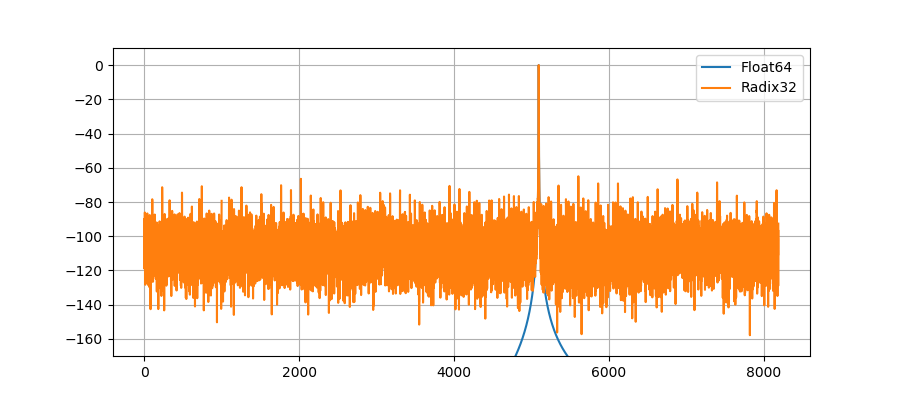

In [12]:
for key, val in results.items():
    plt.plot(20 * np.log10(val), label=key)
plt.legend()
plt.ylim([-170, 10])
plt.grid()
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


<IPython.core.display.Javascript object>


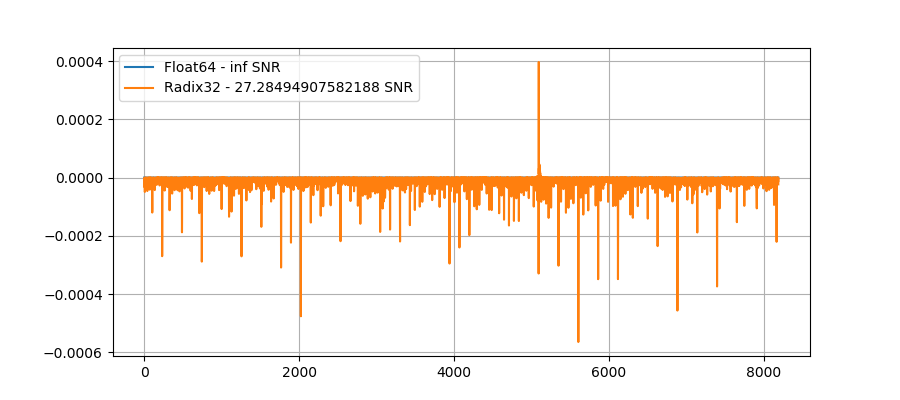

Float64 SNR: inf dB
Radix32 SNR: 27.28494907582188 dB


In [8]:
for key, val in results.items():
    plt.plot(results['Float64'] - val, label=f'{key} - {snr(results["Float64"], val)} SNR')
plt.legend()
plt.grid()
plt.show()

for key, val in results.items():
    print(f'{key} SNR: {snr(results["Float64"], val)} dB')
#     plt.plot(results['Float64'] - val, label=key)

In [9]:
# 4k
# 3,6 Radix32 SNR: 14.079865391453472 dB
# 2,6 Radix32 SNR: 14.079865391453472 dB
# 3,8 Radix32 SNR: 26.36664725009055 dB
# 3,9 Radix32 SNR: 30.506789988477383 dB
# 2,9 Radix32 SNR: 30.506789988477383 dB (no effect)
# 1,9 Radix32 SNR: 29.459487153536415 dB (shit SFDR)
